# Assignment 11 - Updated Version

*by Angelica Hjelm Gardner, Muhammad Farooq, and Omid Golshan Tafti.*

This report is an updated version we worked on according to received feedback.
In this updated version, we've made the following changes:

- Used only one approach for labeling the data and stick with it for the entire assignment;
- Replaced multi-class classification with binary classification so this time, we have defined 2 x 2 models: (1) Start frames Kinect, (2) Start frames PoseNet, (3) Stop/End frames Kinect, and (4) Stop/End frames PoseNet.
- Added additional data augmentation and describe how these are computed in the Notebook;
- Test variants of hidden layers, activation functions, initialization, batch-size, and optimizers;
- Separate 10% of all data for validation (holdout set) and evaluated models on that;
- Added all executable code to the Notebook;
- Included the following metrics: Precision, Recall, F1, Accuracy, and Confusion Matrix.
- Added compute_class_weight from scikit-learn.utils to estimate the class weight;
- Report on the effects of doing different imbalanced dataset techniques; and
- Evaluated the usefulness of the selected classifier(s) in the application context.

## Introduction (*this part is kept intact from the first submission*)

This week, we've performed ML experimentations to recognize the start and stop of exercise sequences from recorded deep squat videos. We trained ML models to distinguish start and stop positions, so that the videos can be cut to only assess sequences showing the actual exercise.

In this report, we go through the deep learning steps: from the preparation of data to defining and experimenting with DL models, as well as evaluating model performance.

At the end of the report, an update about our workflow setup is included to show that we have received and acknowledged feedback about this area from our latest assignment.

<br/>

----

## Table of Contents

1. **Data Preprocessing**

    1.1 Marking Start and Stop

    1.2 Inspect Class Imbalance

2. **Define a Suitable Deep Learning Model**

    2.1 Problem A (Kinect)

    - 2.1.1 Kinect Cut Start model

    - 2.1.2 Kinect Cut Stop model

    2.2 Problem B (PoseNet)

    - 2.2.1 PoseNet Cut Start model

    - 2.2.2 PoseNet Cut Stop model

3. **Conclusions and The Champion Model**

4. **Jira Updates**

----

# 1. Data Preprocessing

We have used three different datasets in this assignment, so for clarification, we'll briefly go through them and what we will be calling them for the rest of the report:

- PoseNet video output (uncut). This is the data we receive when feeding a video input into our PoseNet model and it gives us joint positions in 2D (X, Y) as output. All frames are preserved so each file contains positions from the start of the video until its end. 
We're referring to this as the **posenet_dataset**. 

- Kinect video output (uncut). We received this dataset from stakeholders and it contains joint positions from a Kinect device in 3D (X, Y, Z). All frames are preserved so each file contains positions from the start of the video until its end.
We're referring to this as the **kinect_uncut_dataset**.

- Kinect video output (cut). This is also a dataset we received from stakeholders and each file contains the same Kinect output as the dataset described above, but this time, frames at the start and at the end of the exercise has been removed so the file only contains frames with positions for the actual movement.
We're referring to this as the **kinect_cut_dataset**.

## 1.1 Marking Start and Stop

In the original report, we used four different methods for marking start and stop frames. We were told that sticking to one approach would be better and less confusing, so we chose the method were we approach the solution as a binary classification and therefore, we need a "Start" column where each frame is marked with 0 (Not a start frame) or 1 (Start frame). We also need the same sitatuation with an "End" column.

We will read the CSV files from the datasets mentioned above, find the start and end frame numbers from the cut Kinect dataset and match those frame numbers in Kinect uncut dataset as well as PoseNet dataset. Finally, we'll save this dataset to use for our model training.

The Notebook we used for processing the data can be found here [mark_start_and_end.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment11/2%20mark_start_and_end.ipynb) and the processed and saved CSV files were uploaded to our repository and can be found here: [marked_start_end](https://github.com/digitacs/4dv652-ml/tree/main/datasets/marked_start_end).

In [1]:
import numpy as np
import pandas as pd

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

mark_before =  2
mark_after =  2
save_kinect_as_well = True

cut_dataset_path = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/kinect_good_preprocessed/"
uncut_dataset_path = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/kinect_good_preprocessed_not_cut/"
posetnet_dataset_path = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/posenet-uncut/old_posenet-python/"

In [2]:
def mark_start_and_stop( file_name ):
    print('Marking "{}"'.format(file_name), end='')
    
    try:
        # read diffrent version of the given file name
        cut_data = pd.read_csv(cut_dataset_path+'{}_kinect.csv'.format( file_name ))
        uncut_data = pd.read_csv(uncut_dataset_path+'{}_kinect.csv'.format( file_name ))
        posenet_data = pd.read_csv(posetnet_dataset_path+'{}.csv'.format( file_name ))

        # find the start and end frame number from cutted dataset
        start = cut_data.iloc[0]['FrameNo']
        end = cut_data.iloc[len(cut_data)-1]['FrameNo']

        # find the start and end frame number from uncutted dataset
        start_uncut = uncut_data.iloc[0]['FrameNo']
        end_uncut = uncut_data.iloc[len(uncut_data)-1]['FrameNo']

        # in some cases even uncuted version won't start from zero
        # to be sure we will go for the maximum/maximum :D
        start = np.maximum(start, start_uncut)
        end = np.minimum(end, end_uncut)

        print(' | start:{} - end:{}'.format(start,end), end='')

        # add a new columns for the start/end classes
        posenet_data['start'] = None
        posenet_data['end'] = None
        uncut_data['start'] = None
        uncut_data['end'] = None

        # mark the coresponding frame and it's surrounds in posenet dataset
        posenet_data.loc[
            ((posenet_data['FrameNo'] <= start+mark_after)),
            'start'
        ] = '1'
        
        posenet_data.loc[
            ((posenet_data['FrameNo'] > start+mark_after)),
            'start'
        ] = '0'

        posenet_data.loc[
            ((posenet_data['FrameNo'] < end-mark_before)),
            'end'
        ] = '0'
        
        posenet_data.loc[
            ((posenet_data['FrameNo'] >= end-mark_before)),
            'end'
        ] = '1'


        # mark the coresponding frame and it's surrounds in uncut kinect dataset
        uncut_data.loc[
            ((uncut_data['FrameNo'] <= start+mark_after)),
            'start'
        ] = '1'
        
        uncut_data.loc[
            ((uncut_data['FrameNo'] > start+mark_after)),
            'start'
        ] = '0'

        uncut_data.loc[
            ((uncut_data['FrameNo'] < end-mark_before)),
            'end'
        ] = '0'
        
        uncut_data.loc[
            ((uncut_data['FrameNo'] >= end-mark_before)),
            'end'
        ] = '1'

        print(' Done!')
        
        return posenet_data, uncut_data
    
    except IOError as e:
        print(e)
        return None,None

Process and save the A-series files.

In [3]:
for a in range(1,160):
    # marke start and end frames
    posenet, uncut_kinect = mark_start_and_stop( 'A{}'.format(a) )
    
    # jump to next file if current one is unavailable
    if(posenet is None):
        continue
    
    # save posenet dataset to a csv file
    posenet.to_csv('A{}.csv'.format(a),index=False)
    
    if save_kinect_as_well:
        # save uncut kinect dataset to a csv file
        uncut_kinect.to_csv('A{}_kinect.csv'.format(a),index=False)

Marking "A1" | start:68.0 - end:179.0 Done!
Marking "A2" | start:70.0 - end:223.0 Done!
Marking "A3" | start:55.0 - end:182.0 Done!
Marking "A4" | start:56.0 - end:219.0 Done!
Marking "A5" | start:55.0 - end:168.0 Done!
Marking "A6" | start:30.0 - end:172.0 Done!
Marking "A7" | start:46.0 - end:187.0 Done!
Marking "A8" | start:51.0 - end:194.0 Done!
Marking "A9" | start:41.0 - end:174.0 Done!
Marking "A10" | start:42.0 - end:202.0 Done!
Marking "A11" | start:24.0 - end:241.0 Done!
Marking "A12" | start:13.0 - end:179.0 Done!
Marking "A13" | start:14.0 - end:178.0 Done!
Marking "A14" | start:0.0 - end:162.0 Done!
Marking "A15" | start:12.0 - end:134.0 Done!
Marking "A16" | start:30.0 - end:150.0 Done!
Marking "A17" | start:21.0 - end:142.0 Done!
Marking "A18" | start:54.0 - end:167.0 Done!
Marking "A19" | start:29.0 - end:148.0 Done!
Marking "A20" | start:24.0 - end:127.0 Done!
Marking "A21" | start:24.0 - end:142.0 Done!
Marking "A22" | start:38.0 - end:135.0 Done!
Marking "A23" | star

Process and save the B-series files.

In [4]:
for b in range(1,23):
    # marke start and end frames
    posenet,uncut_kinect = mark_start_and_stop( 'B{}'.format(b) )
    
    # jump to next file if current one is unavailable
    if(posenet is None):
        continue
        
    # save posenet dataset to a csv file
    posenet.to_csv('B{}.csv'.format(b),index=False)
    
    if save_kinect_as_well:
        # save uncut kinect dataset to a csv file
        uncut_kinect.to_csv('B{}_kinect.csv'.format(b),index=False)

Marking "B1" | start:69.0 - end:121.0 Done!
Marking "B2" | start:29.0 - end:117.0 Done!
Marking "B3" | start:23.0 - end:109.0 Done!
Marking "B4" | start:0.0 - end:98.0 Done!
Marking "B5" | start:41.0 - end:139.0 Done!
Marking "B6" | start:157.0 - end:262.0 Done!
Marking "B7" | start:123.0 - end:218.0 Done!
Marking "B8" | start:108.0 - end:195.0 Done!
Marking "B9" | start:96.0 - end:183.0 Done!
Marking "B10" | start:108.0 - end:193.0 Done!
Marking "B11" | start:70.0 - end:190.0 Done!
Marking "B12" | start:106.0 - end:189.0 Done!
Marking "B13" | start:153.0 - end:239.0 Done!
Marking "B14" | start:113.0 - end:204.0 Done!
Marking "B15" | start:111.0 - end:203.0 Done!
Marking "B16" | start:124.0 - end:207.0 Done!
Marking "B17" | start:110.0 - end:207.0 Done!
Marking "B18" | start:108.0 - end:196.0 Done!
Marking "B19" | start:101.0 - end:195.0 Done!
Marking "B20" | start:98.0 - end:196.0 Done!
Marking "B21" | start:98.0 - end:200.0 Done!
Marking "B22" | start:90.0 - end:173.0 Done!


## 1.2 Inspect Class Imbalance

Finally, we want to inspect the class imbalance in the dataset we just saved by loading the files and group them according to start and stop frames.

This class imbalance check shows us the small amount of start and stop frames, from which we can understand that we will need to implement some imbalanced techniques during model training.

In [5]:
dataset = None

for i in range(1,160):
  try:
    data = pd.read_csv('A{}_kinect.csv'.format(i), index_col=0)
    
    if dataset is None:
      dataset = data
    else:
      dataset = pd.concat((dataset, data),ignore_index=True)
  except:
    print('Could not load file A{}_kinect.csv'.format(i))

for i in range(1,23):
  try:
    data = pd.read_csv('B{}_kinect.csv'.format(i), index_col=0)
    dataset = pd.concat((dataset, data),ignore_index=True)
  except:
    print('Could not load file B{}_kinect.csv'.format(i))

print('\n', dataset.shape)
print(dataset['start'].unique())
print(dataset['end'].unique())

Could not load file A60_kinect.csv
Could not load file A107_kinect.csv

 (37782, 41)
[1 0]
[0 1]


How many start frames do we have?

In [6]:
train_gc = dataset.groupby(['start']).size()
print(
    'Total: {}\n\nStart: {} ({:.2f}% of total)\n'
    .format(
      len(dataset), 
      train_gc[1],
      train_gc[1] / len(dataset),
    )
  )

Total: 37782

Start: 7814 (0.21% of total)



How many stop frames do we have?

In [7]:
train_gc = dataset.groupby(['end']).size()
print(
    'Total: {}\n\nEnd: {} ({:.2f}% of total)\n'
    .format(
      len(dataset), 
      train_gc[1],
      train_gc[1] / len(dataset),
    )
  )

Total: 37782

End: 7037 (0.19% of total)



# 2. Define a Suitable Deep Learning Model

We approached solving this problem as a multi-class solution in the first submission, but after experimenting with binary classification instead - we found that it was much easier to reach a better performance for the models, so we switched to that approach.

In this section, we present:

- Start model for Kinect (problem A)
- Stop model for Kinect (problem A)
- Start model for PoseNet (problem B)
- Stop model for PoseNet (problem B)

We will also try each model in three different scenarios:
- Baseline model 
- Using the imbalance technique of class weights
- Using the imbalance technique of oversamling

## 2.1 Problem A (Kinect)

In this section, we'll work with the Kinect Start and Stop models.

### 2.1.1 Kinect Cut Start model

We have worked in [cut_start_kinect.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment13/cut_start_kinect.ipynb) when experimenting with 11 versions of this model, and the experiment results are saved in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=[%2214b3d62fe0ac449d98a19e883e57133c%22,%226f3634d228d643938f7a6d41ffd8f46e%22,%221caa916678fd4b2eab0928c70a4ec451%22,%227403b22119ba465c8c033f93539a2d48%22,%22fbba435e3df043029f755fbfd6cf20c3%22,%22e75edd96d07e4bd2a4555786965a35c2%22,%22c92ade4517844c7182ca5bf24a1c7e17%22,%22140fe03e83f94946b953f02d2e37cacd%22,%225bc55dc1d2534a259459bc711d10cac9%22,%223fdb4eee8e7c47aca493d7ac0c77c5e1%22,%22a35c4332c8d94eba9a9d082d265617c6%22]&experiment=0) for easy comparison.

Let's start by loading the dataset.

In [8]:
data_path = 'https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/marked_start_end/'

df = None

In [9]:
# Loading A-files
for i in range(1, 160):
  try:
    dataset = pd.read_csv(data_path + 'A{}_kinect.csv'.format(i))
    dataset.drop(columns=['FrameNo'], inplace=True)

    if df is None:
      df = dataset
    else:
      df = pd.concat((df, dataset), ignore_index=True)

  except IOError as e:
    print("Error in reading files: A{}_kinect.csv".format(i), e)

# Loading B-files
for i in range(1, 23):
  try:
    dataset = pd.read_csv(data_path + 'B{}_kinect.csv'.format(i))
    dataset.drop(columns=['FrameNo'], inplace=True)

    if df is None:
      df = dataset
    else:
      df = pd.concat((df, dataset), ignore_index=True)

  except IOError as e:
    print("Error in reading file: B{}_kinect.csv".format(i), e)

print(df.shape)

Error in reading files: A60_kinect.csv HTTP Error 404: Not Found
Error in reading files: A107_kinect.csv HTTP Error 404: Not Found
(37782, 41)


We will use some data augmentation. In the previous submission of this report, we only mirrored the data on the X-axis using addition. But now we have updated that method and also added another augmentation method which will stretch by the percentage of choice.

In [10]:
def mirror(data, axis, append=False):
    try:
        
        if axis == 'a':
            target_labels = [col for col in data.columns]
        else:
            axis = "_" + axis
            target_labels = [col for col in data.columns if axis in col]

        aug_data_mirror = data.copy()

        for t in target_labels:
            temp = -aug_data_mirror[t]
            aug_data_mirror = aug_data_mirror.assign(**{t: temp.values})

        if append:
            return data.append(aug_data_mirror,ignore_index=True)

        return aug_data_mirror
    
    except IOError as e:
        print(e)
        return None

In [11]:
def augMultiplier(data, multiplier, append=False):
    
    try:
        aug_data_offset = data.copy()
        aug_data_offset *= multiplier
        if append:
            return data.append(aug_data_offset,ignore_index=True)
        
        return aug_data_offset
    
    except IOError as e:
        print(e)
        return None

In [12]:
print('Initial shape:', df.shape, '\n')

df = mirror(df,'x', append=True)
print('Shape after mirror augmentation:', df.shape)

Initial shape: (37782, 41) 

Shape after mirror augmentation: (75564, 41)


In [13]:
df = augMultiplier(df, 1.5, append=True)
print('Shape after stretching:', df.shape)

Shape after stretching: (151128, 41)


One of the class imbalance techniques that we will be using is Oversampling. We won't use undersampling because we don't want to reduce the dataset. 

Oversampling is a type of data augmentation for the minority class (in our case: the start/stop frames) where we replicate that minority class until we get the class balance we're looking for. <br />
We will be using the SMOTE technique which works by creating synthetic examples of the minority class because it forces the decision region of the minority class to become more general.

So, when using oversampling to train the model, we will use the resampled_X and resampled_y sets, but when setting class weights, we will use the normal X and y sets.

In [14]:
X = df.drop(columns=['start', 'end'])
y = df['start']
y = y.astype(int)

from sklearn.utils import shuffle

X, y = shuffle(X, y)

In [69]:
# install imblearn module
!pip install imblearn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [70]:
from imblearn.over_sampling import SMOTE

random_state = 42
np.random.seed(random_state)

sm = SMOTE(random_state=random_state)
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

(237442, 26)
(237442,)


Next, we'll split the dataset into train, validation, and test sets:

- The validation set is used during model fitting to evaluate the loss and other evaluation metrics.
- The test set is unused during the training phase and is used at the end to evaluate how well the model generalizes to new data (i.e. a holdout set). This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

We also normalize the input features using the sklearn StandardScaler. StandardScaler is only fit using X_train. As we want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

The ratio between the splits are 10% (0.1) for validation and then the rest 90% (0.9) will be split into 20:80 ratio where 20% is for test set and the remaining 80% for training.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [17]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=random_state)
resampled_X_train, resampled_X_val, resampled_y_train, resampled_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

resampled_scaler = StandardScaler()
resampled_X_train = resampled_scaler.fit_transform(resampled_X_train)

resampled_X_val = resampled_scaler.transform(resampled_X_val)
resampled_X_test = resampled_scaler.transform(resampled_X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (108812,)
Validation labels shape: (27203,)
Test labels shape: (15113,) 

Training features shape: (108812, 39)
Validation features shape: (27203, 39)
Test features shape: (15113, 39)


The data preparation steps are finished and we'll start training the DL model. We have been working with Dense layers for this model.

Let's start by defining the experimentation configurations. We will use early stopping during training, and common binary classification metrics for evaluation.

In [19]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC

early_stopping = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

EPOCHS = 500
BATCH_SIZE = 2000

METRICS = [
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

# Input and output size
input_dim = X_train.shape[1]
output_size = 1

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


The **create_model()** function will create and return the DL model to us.
We're using a function for this purpose because we will be creating several models so it's convenient to not repeat the model architecture and only supply different parameter values.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout

def create_model(units, activation, kernel_initializer, output_activation, optimizer):
    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(0.2))
    if not output_activation:
      model.add(Dense(units=output_size))
    else:
      model.add(Dense(units=output_size, activation=output_activation))

    model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=METRICS)

    print(model.summary())

    return model

When comparing the parameter value experimentations in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=%5B%2214b3d62fe0ac449d98a19e883e57133c%22,%226f3634d228d643938f7a6d41ffd8f46e%22,%221caa916678fd4b2eab0928c70a4ec451%22,%227403b22119ba465c8c033f93539a2d48%22,%22fbba435e3df043029f755fbfd6cf20c3%22,%22e75edd96d07e4bd2a4555786965a35c2%22,%22c92ade4517844c7182ca5bf24a1c7e17%22,%22140fe03e83f94946b953f02d2e37cacd%22,%225bc55dc1d2534a259459bc711d10cac9%22,%223fdb4eee8e7c47aca493d7ac0c77c5e1%22,%22a35c4332c8d94eba9a9d082d265617c6%22%5D&experiment=0) we could draw a few conclusions:

- ReLU gave the highest accuracy as activation function for hidden layers;
- Larger batch sizes, such as 2000, increased the accuracy. Perhaps because the dataset is imbalanced so it makes sure some examples of each class in each batch?
- Lower learning rate for higher batch sizes worked well, but larger learning rates were better for smaller batch sizes;
- Adam was the best performing optimizer; and
- A greater value for units in the Dense layers (such as 64) made the models learn better.

To easily compare the imbalanced dataset techniques with each other and the baseline, we will stick to the same (and best performing) parameter values 

We will start by looking at the Baseline model version. Let us give it some parameter values and start the training phase.

In [21]:
baseline_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

baseline_history = baseline_model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 2s 14ms/step - loss: 0.6046 - accuracy: 0.6448 - precision: 0.2431 - recall: 0.3128 - auc: 0.5853 - prc: 0.2418 - val_loss: 0.3947 - val_accuracy: 0.8119 - val_precision: 0.6142 - val_recall: 0.2424 - val_auc: 0.8301 - val_prc: 0.4933
Epoch 2/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4002 - accuracy:

Epoch 27/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1972 - accuracy: 0.9177 - precision: 0.8641 - recall: 0.7141 - auc: 0.9633 - prc: 0.8854 - val_loss: 0.1830 - val_accuracy: 0.9262 - val_precision: 0.9072 - val_recall: 0.7162 - val_auc: 0.9696 - val_prc: 0.9049
Epoch 28/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1936 - accuracy: 0.9199 - precision: 0.8662 - recall: 0.7220 - auc: 0.9648 - prc: 0.8870 - val_loss: 0.1806 - val_accuracy: 0.9293 - val_precision: 0.8935 - val_recall: 0.7473 - val_auc: 0.9705 - val_prc: 0.9067
Epoch 29/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9199 - precision: 0.8673 - recall: 0.7242 - auc: 0.9653 - prc: 0.8919 - val_loss: 0.1776 - val_accuracy: 0.9316 - val_precision: 0.9013 - val_recall: 0.7516 - val_auc: 0.9721 - val_prc: 0.9112
Epoch 30/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1894 - accuracy: 0.9218 - precision: 0.8726 - recall: 0.7293

55/55 [==============================] - 0s 4ms/step - loss: 0.1503 - accuracy: 0.9403 - precision: 0.8958 - recall: 0.8037 - auc: 0.9795 - prc: 0.9322 - val_loss: 0.1368 - val_accuracy: 0.9493 - val_precision: 0.8993 - val_recall: 0.8497 - val_auc: 0.9840 - val_prc: 0.9469
Epoch 56/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1499 - accuracy: 0.9409 - precision: 0.8903 - recall: 0.8152 - auc: 0.9795 - prc: 0.9311 - val_loss: 0.1352 - val_accuracy: 0.9488 - val_precision: 0.9167 - val_recall: 0.8273 - val_auc: 0.9845 - val_prc: 0.9482
Epoch 57/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1466 - accuracy: 0.9418 - precision: 0.8961 - recall: 0.8112 - auc: 0.9805 - prc: 0.9343 - val_loss: 0.1346 - val_accuracy: 0.9481 - val_precision: 0.9218 - val_recall: 0.8181 - val_auc: 0.9847 - val_prc: 0.9485
Epoch 58/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1485 - accuracy: 0.9410 - precision: 0.8975 - recall: 0.8086 - auc: 0.980

55/55 [==============================] - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9491 - precision: 0.9030 - recall: 0.8436 - auc: 0.9846 - prc: 0.9472 - val_loss: 0.1145 - val_accuracy: 0.9562 - val_precision: 0.9214 - val_recall: 0.8615 - val_auc: 0.9886 - val_prc: 0.9615
Epoch 84/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1268 - accuracy: 0.9497 - precision: 0.9051 - recall: 0.8462 - auc: 0.9854 - prc: 0.9507 - val_loss: 0.1137 - val_accuracy: 0.9568 - val_precision: 0.9292 - val_recall: 0.8563 - val_auc: 0.9886 - val_prc: 0.9621
Epoch 85/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1293 - accuracy: 0.9488 - precision: 0.9017 - recall: 0.8469 - auc: 0.9848 - prc: 0.9493 - val_loss: 0.1133 - val_accuracy: 0.9560 - val_precision: 0.9302 - val_recall: 0.8511 - val_auc: 0.9885 - val_prc: 0.9619
Epoch 86/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9489 - precision: 0.9014 - recall: 0.8423 - auc: 0.984

55/55 [==============================] - 0s 4ms/step - loss: 0.1148 - accuracy: 0.9539 - precision: 0.9085 - recall: 0.8635 - auc: 0.9877 - prc: 0.9584 - val_loss: 0.1010 - val_accuracy: 0.9618 - val_precision: 0.9381 - val_recall: 0.8727 - val_auc: 0.9908 - val_prc: 0.9700
Epoch 112/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.9547 - precision: 0.9089 - recall: 0.8675 - auc: 0.9880 - prc: 0.9593 - val_loss: 0.1018 - val_accuracy: 0.9603 - val_precision: 0.9458 - val_recall: 0.8570 - val_auc: 0.9907 - val_prc: 0.9700
Epoch 113/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9537 - precision: 0.9100 - recall: 0.8630 - auc: 0.9877 - prc: 0.9590 - val_loss: 0.1007 - val_accuracy: 0.9622 - val_precision: 0.9429 - val_recall: 0.8696 - val_auc: 0.9908 - val_prc: 0.9701
Epoch 114/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9537 - precision: 0.9113 - recall: 0.8605 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.9567 - precision: 0.9090 - recall: 0.8771 - auc: 0.9891 - prc: 0.9635 - val_loss: 0.0921 - val_accuracy: 0.9653 - val_precision: 0.9433 - val_recall: 0.8853 - val_auc: 0.9921 - val_prc: 0.9748
Epoch 140/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1064 - accuracy: 0.9577 - precision: 0.9113 - recall: 0.8804 - auc: 0.9894 - prc: 0.9641 - val_loss: 0.0918 - val_accuracy: 0.9655 - val_precision: 0.9426 - val_recall: 0.8872 - val_auc: 0.9921 - val_prc: 0.9748
Epoch 141/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1072 - accuracy: 0.9576 - precision: 0.9128 - recall: 0.8790 - auc: 0.9892 - prc: 0.9638 - val_loss: 0.0913 - val_accuracy: 0.9661 - val_precision: 0.9346 - val_recall: 0.8992 - val_auc: 0.9922 - val_prc: 0.9750
Epoch 142/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1061 - accuracy: 0.9577 - precision: 0.9122 - recall: 0.8818 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9604 - precision: 0.9195 - recall: 0.8871 - auc: 0.9903 - prc: 0.9685 - val_loss: 0.0867 - val_accuracy: 0.9668 - val_precision: 0.9475 - val_recall: 0.8885 - val_auc: 0.9929 - val_prc: 0.9775
Epoch 168/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 0.9593 - precision: 0.9176 - recall: 0.8819 - auc: 0.9903 - prc: 0.9677 - val_loss: 0.0857 - val_accuracy: 0.9685 - val_precision: 0.9400 - val_recall: 0.9052 - val_auc: 0.9931 - val_prc: 0.9780
Epoch 169/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9590 - precision: 0.9148 - recall: 0.8837 - auc: 0.9900 - prc: 0.9670 - val_loss: 0.0861 - val_accuracy: 0.9689 - val_precision: 0.9430 - val_recall: 0.9040 - val_auc: 0.9930 - val_prc: 0.9777
Epoch 170/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 0.9594 - precision: 0.9141 - recall: 0.8866 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0970 - accuracy: 0.9615 - precision: 0.9202 - recall: 0.8917 - auc: 0.9910 - prc: 0.9704 - val_loss: 0.0805 - val_accuracy: 0.9706 - val_precision: 0.9447 - val_recall: 0.9109 - val_auc: 0.9937 - val_prc: 0.9802
Epoch 196/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0950 - accuracy: 0.9617 - precision: 0.9191 - recall: 0.8931 - auc: 0.9912 - prc: 0.9712 - val_loss: 0.0808 - val_accuracy: 0.9700 - val_precision: 0.9450 - val_recall: 0.9077 - val_auc: 0.9938 - val_prc: 0.9800
Epoch 197/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0940 - accuracy: 0.9623 - precision: 0.9209 - recall: 0.8937 - auc: 0.9915 - prc: 0.9718 - val_loss: 0.0805 - val_accuracy: 0.9699 - val_precision: 0.9478 - val_recall: 0.9041 - val_auc: 0.9937 - val_prc: 0.9799
Epoch 198/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0939 - accuracy: 0.9624 - precision: 0.9219 - recall: 0.8933 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9646 - precision: 0.9266 - recall: 0.8999 - auc: 0.9923 - prc: 0.9748 - val_loss: 0.0775 - val_accuracy: 0.9709 - val_precision: 0.9489 - val_recall: 0.9082 - val_auc: 0.9942 - val_prc: 0.9819
Epoch 224/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0915 - accuracy: 0.9633 - precision: 0.9222 - recall: 0.8982 - auc: 0.9917 - prc: 0.9736 - val_loss: 0.0759 - val_accuracy: 0.9714 - val_precision: 0.9454 - val_recall: 0.9145 - val_auc: 0.9945 - val_prc: 0.9826
Epoch 225/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9625 - precision: 0.9164 - recall: 0.8991 - auc: 0.9919 - prc: 0.9730 - val_loss: 0.0767 - val_accuracy: 0.9711 - val_precision: 0.9455 - val_recall: 0.9129 - val_auc: 0.9944 - val_prc: 0.9823
Epoch 226/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0905 - accuracy: 0.9638 - precision: 0.9213 - recall: 0.9010 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0882 - accuracy: 0.9637 - precision: 0.9199 - recall: 0.9026 - auc: 0.9926 - prc: 0.9750 - val_loss: 0.0728 - val_accuracy: 0.9721 - val_precision: 0.9449 - val_recall: 0.9185 - val_auc: 0.9949 - val_prc: 0.9833
Epoch 252/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0873 - accuracy: 0.9656 - precision: 0.9261 - recall: 0.9076 - auc: 0.9927 - prc: 0.9769 - val_loss: 0.0731 - val_accuracy: 0.9724 - val_precision: 0.9450 - val_recall: 0.9200 - val_auc: 0.9949 - val_prc: 0.9835
Epoch 253/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 0.9653 - precision: 0.9266 - recall: 0.9048 - auc: 0.9928 - prc: 0.9767 - val_loss: 0.0724 - val_accuracy: 0.9731 - val_precision: 0.9493 - val_recall: 0.9191 - val_auc: 0.9950 - val_prc: 0.9838
Epoch 254/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9647 - precision: 0.9230 - recall: 0.9035 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0857 - accuracy: 0.9648 - precision: 0.9235 - recall: 0.9044 - auc: 0.9929 - prc: 0.9764 - val_loss: 0.0703 - val_accuracy: 0.9725 - val_precision: 0.9482 - val_recall: 0.9171 - val_auc: 0.9951 - val_prc: 0.9841
Epoch 280/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0835 - accuracy: 0.9665 - precision: 0.9282 - recall: 0.9070 - auc: 0.9932 - prc: 0.9778 - val_loss: 0.0700 - val_accuracy: 0.9734 - val_precision: 0.9514 - val_recall: 0.9182 - val_auc: 0.9952 - val_prc: 0.9844
Epoch 281/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9662 - precision: 0.9257 - recall: 0.9100 - auc: 0.9934 - prc: 0.9783 - val_loss: 0.0694 - val_accuracy: 0.9739 - val_precision: 0.9416 - val_recall: 0.9315 - val_auc: 0.9953 - val_prc: 0.9848
Epoch 282/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0855 - accuracy: 0.9652 - precision: 0.9238 - recall: 0.9061 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0813 - accuracy: 0.9663 - precision: 0.9278 - recall: 0.9080 - auc: 0.9934 - prc: 0.9789 - val_loss: 0.0672 - val_accuracy: 0.9744 - val_precision: 0.9501 - val_recall: 0.9248 - val_auc: 0.9956 - val_prc: 0.9858
Epoch 308/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.9674 - precision: 0.9293 - recall: 0.9098 - auc: 0.9937 - prc: 0.9793 - val_loss: 0.0665 - val_accuracy: 0.9747 - val_precision: 0.9472 - val_recall: 0.9292 - val_auc: 0.9959 - val_prc: 0.9864
Epoch 309/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0804 - accuracy: 0.9672 - precision: 0.9255 - recall: 0.9144 - auc: 0.9939 - prc: 0.9789 - val_loss: 0.0673 - val_accuracy: 0.9737 - val_precision: 0.9541 - val_recall: 0.9168 - val_auc: 0.9956 - val_prc: 0.9861
Epoch 310/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9668 - precision: 0.9296 - recall: 0.9078 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9690 - precision: 0.9326 - recall: 0.9158 - auc: 0.9941 - prc: 0.9803 - val_loss: 0.0643 - val_accuracy: 0.9754 - val_precision: 0.9517 - val_recall: 0.9280 - val_auc: 0.9960 - val_prc: 0.9871
Epoch 336/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9695 - precision: 0.9331 - recall: 0.9185 - auc: 0.9945 - prc: 0.9816 - val_loss: 0.0641 - val_accuracy: 0.9756 - val_precision: 0.9537 - val_recall: 0.9267 - val_auc: 0.9961 - val_prc: 0.9872
Epoch 337/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0770 - accuracy: 0.9687 - precision: 0.9300 - recall: 0.9167 - auc: 0.9941 - prc: 0.9806 - val_loss: 0.0636 - val_accuracy: 0.9764 - val_precision: 0.9498 - val_recall: 0.9353 - val_auc: 0.9962 - val_prc: 0.9872
Epoch 338/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0769 - accuracy: 0.9687 - precision: 0.9328 - recall: 0.9163 - auc: 0.

Let's take a look at the training history by producing plots of the baseline model's accuracy and loss on the training and validation set. These are useful to check for overfitting.

The learning history seems to be not great but quite ok and normal, nothing that stands out as weird to us.

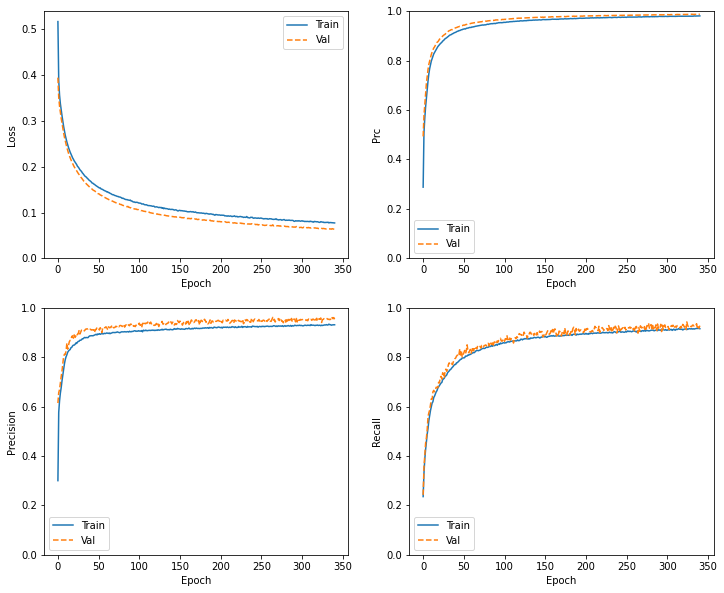

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_history(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_history(baseline_history)

The role of bias in a model is to learn a preference for the most frequent class and by removing the bias from the model, we will force it not to use this strategy. So next, we're going to train another model with class weights to see how this imbalanced dataset technique will affect the model performance.

First, we need to calculate the class weights and then use them when computing the loss function so that when can make the underrepresented class more prominent and make sure the model learns more about it.

In [23]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for start frames:', class_weights[1])
print('Weight for normal frames:', class_weights[0])

Weight for start frames: 2.4155751898059763
Weight for normal frames: 0.6305091031301788


In [24]:
weighted_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

weighted_history = weighted_model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
55/55 [==============================] - 2s 14ms/step - loss: 0.7997 - accuracy: 0.6629 - precision: 0.3815 - recall: 0.9034 - auc: 0.8256 - prc: 0.5724 - val_loss: 0.5105 - val_accuracy: 0.6902 - val_precision: 0.3956 - val_re

Epoch 26/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2499 - accuracy: 0.8640 - precision: 0.6146 - recall: 0.9261 - auc: 0.9626 - prc: 0.8778 - val_loss: 0.2464 - val_accuracy: 0.8708 - val_precision: 0.6249 - val_recall: 0.9376 - val_auc: 0.9694 - val_prc: 0.9005
Epoch 27/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2449 - accuracy: 0.8674 - precision: 0.6214 - recall: 0.9277 - auc: 0.9644 - prc: 0.8848 - val_loss: 0.2446 - val_accuracy: 0.8737 - val_precision: 0.6307 - val_recall: 0.9388 - val_auc: 0.9701 - val_prc: 0.9020
Epoch 28/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2407 - accuracy: 0.8711 - precision: 0.6253 - recall: 0.9310 - auc: 0.9651 - prc: 0.8836 - val_loss: 0.2360 - val_accuracy: 0.8807 - val_precision: 0.6464 - val_recall: 0.9337 - val_auc: 0.9708 - val_prc: 0.9048
Epoch 29/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2395 - accuracy: 0.8730 - precision: 0.6301 - recall: 0.9230

55/55 [==============================] - 0s 4ms/step - loss: 0.1912 - accuracy: 0.9062 - precision: 0.7041 - recall: 0.9479 - auc: 0.9783 - prc: 0.9226 - val_loss: 0.1825 - val_accuracy: 0.9185 - val_precision: 0.7303 - val_recall: 0.9603 - val_auc: 0.9837 - val_prc: 0.9415
Epoch 55/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1905 - accuracy: 0.9066 - precision: 0.7062 - recall: 0.9472 - auc: 0.9785 - prc: 0.9228 - val_loss: 0.1777 - val_accuracy: 0.9230 - val_precision: 0.7447 - val_recall: 0.9547 - val_auc: 0.9836 - val_prc: 0.9406
Epoch 56/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1897 - accuracy: 0.9088 - precision: 0.7098 - recall: 0.9450 - auc: 0.9784 - prc: 0.9222 - val_loss: 0.1858 - val_accuracy: 0.9162 - val_precision: 0.7227 - val_recall: 0.9646 - val_auc: 0.9839 - val_prc: 0.9415
Epoch 57/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1904 - accuracy: 0.9070 - precision: 0.7058 - recall: 0.9462 - auc: 0.978

55/55 [==============================] - 0s 4ms/step - loss: 0.1621 - accuracy: 0.9231 - precision: 0.7429 - recall: 0.9549 - auc: 0.9839 - prc: 0.9379 - val_loss: 0.1483 - val_accuracy: 0.9380 - val_precision: 0.7856 - val_recall: 0.9630 - val_auc: 0.9887 - val_prc: 0.9579
Epoch 83/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1624 - accuracy: 0.9251 - precision: 0.7497 - recall: 0.9552 - auc: 0.9840 - prc: 0.9405 - val_loss: 0.1493 - val_accuracy: 0.9365 - val_precision: 0.7789 - val_recall: 0.9673 - val_auc: 0.9887 - val_prc: 0.9577
Epoch 84/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1608 - accuracy: 0.9251 - precision: 0.7498 - recall: 0.9588 - auc: 0.9844 - prc: 0.9401 - val_loss: 0.1454 - val_accuracy: 0.9406 - val_precision: 0.7924 - val_recall: 0.9653 - val_auc: 0.9889 - val_prc: 0.9589
Epoch 85/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9257 - precision: 0.7528 - recall: 0.9541 - auc: 0.984

55/55 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9322 - precision: 0.7706 - recall: 0.9608 - auc: 0.9871 - prc: 0.9506 - val_loss: 0.1284 - val_accuracy: 0.9474 - val_precision: 0.8135 - val_recall: 0.9671 - val_auc: 0.9910 - val_prc: 0.9661
Epoch 111/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1440 - accuracy: 0.9335 - precision: 0.7732 - recall: 0.9597 - auc: 0.9871 - prc: 0.9513 - val_loss: 0.1369 - val_accuracy: 0.9409 - val_precision: 0.7884 - val_recall: 0.9762 - val_auc: 0.9911 - val_prc: 0.9660
Epoch 112/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1429 - accuracy: 0.9340 - precision: 0.7774 - recall: 0.9616 - auc: 0.9874 - prc: 0.9530 - val_loss: 0.1297 - val_accuracy: 0.9461 - val_precision: 0.8064 - val_recall: 0.9726 - val_auc: 0.9912 - val_prc: 0.9668
Epoch 113/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1434 - accuracy: 0.9333 - precision: 0.7739 - recall: 0.9599 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9390 - precision: 0.7886 - recall: 0.9647 - auc: 0.9891 - prc: 0.9576 - val_loss: 0.1117 - val_accuracy: 0.9553 - val_precision: 0.8405 - val_recall: 0.9675 - val_auc: 0.9927 - val_prc: 0.9731
Epoch 139/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1306 - accuracy: 0.9388 - precision: 0.7881 - recall: 0.9630 - auc: 0.9893 - prc: 0.9596 - val_loss: 0.1193 - val_accuracy: 0.9501 - val_precision: 0.8189 - val_recall: 0.9740 - val_auc: 0.9926 - val_prc: 0.9714
Epoch 140/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 0.9391 - precision: 0.7893 - recall: 0.9649 - auc: 0.9891 - prc: 0.9598 - val_loss: 0.1176 - val_accuracy: 0.9513 - val_precision: 0.8233 - val_recall: 0.9730 - val_auc: 0.9927 - val_prc: 0.9719
Epoch 141/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1305 - accuracy: 0.9393 - precision: 0.7883 - recall: 0.9650 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1232 - accuracy: 0.9442 - precision: 0.8027 - recall: 0.9674 - auc: 0.9904 - prc: 0.9641 - val_loss: 0.1101 - val_accuracy: 0.9549 - val_precision: 0.8360 - val_recall: 0.9728 - val_auc: 0.9936 - val_prc: 0.9748
Epoch 167/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.9429 - precision: 0.7999 - recall: 0.9671 - auc: 0.9904 - prc: 0.9636 - val_loss: 0.1089 - val_accuracy: 0.9555 - val_precision: 0.8363 - val_recall: 0.9756 - val_auc: 0.9938 - val_prc: 0.9758
Epoch 168/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9448 - precision: 0.8056 - recall: 0.9687 - auc: 0.9907 - prc: 0.9643 - val_loss: 0.1074 - val_accuracy: 0.9559 - val_precision: 0.8372 - val_recall: 0.9767 - val_auc: 0.9938 - val_prc: 0.9751
Epoch 169/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1265 - accuracy: 0.9428 - precision: 0.7985 - recall: 0.9664 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1160 - accuracy: 0.9471 - precision: 0.8121 - recall: 0.9707 - auc: 0.9915 - prc: 0.9668 - val_loss: 0.0994 - val_accuracy: 0.9599 - val_precision: 0.8528 - val_recall: 0.9744 - val_auc: 0.9945 - val_prc: 0.9795
Epoch 195/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1172 - accuracy: 0.9471 - precision: 0.8114 - recall: 0.9684 - auc: 0.9912 - prc: 0.9668 - val_loss: 0.0975 - val_accuracy: 0.9607 - val_precision: 0.8559 - val_recall: 0.9737 - val_auc: 0.9945 - val_prc: 0.9790
Epoch 196/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1156 - accuracy: 0.9481 - precision: 0.8151 - recall: 0.9695 - auc: 0.9914 - prc: 0.9667 - val_loss: 0.1023 - val_accuracy: 0.9568 - val_precision: 0.8395 - val_recall: 0.9783 - val_auc: 0.9946 - val_prc: 0.9789
Epoch 197/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1163 - accuracy: 0.9467 - precision: 0.8091 - recall: 0.9718 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1114 - accuracy: 0.9494 - precision: 0.8181 - recall: 0.9720 - auc: 0.9921 - prc: 0.9688 - val_loss: 0.0896 - val_accuracy: 0.9632 - val_precision: 0.8676 - val_recall: 0.9698 - val_auc: 0.9951 - val_prc: 0.9812
Epoch 223/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1089 - accuracy: 0.9508 - precision: 0.8236 - recall: 0.9715 - auc: 0.9924 - prc: 0.9714 - val_loss: 0.0947 - val_accuracy: 0.9615 - val_precision: 0.8567 - val_recall: 0.9772 - val_auc: 0.9950 - val_prc: 0.9803
Epoch 224/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9495 - precision: 0.8187 - recall: 0.9710 - auc: 0.9920 - prc: 0.9684 - val_loss: 0.0935 - val_accuracy: 0.9616 - val_precision: 0.8598 - val_recall: 0.9728 - val_auc: 0.9950 - val_prc: 0.9809
Epoch 225/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1101 - accuracy: 0.9504 - precision: 0.8221 - recall: 0.9702 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1031 - accuracy: 0.9531 - precision: 0.8296 - recall: 0.9708 - auc: 0.9931 - prc: 0.9723 - val_loss: 0.0938 - val_accuracy: 0.9611 - val_precision: 0.8531 - val_recall: 0.9810 - val_auc: 0.9956 - val_prc: 0.9828
Epoch 251/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1061 - accuracy: 0.9506 - precision: 0.8203 - recall: 0.9743 - auc: 0.9927 - prc: 0.9711 - val_loss: 0.0916 - val_accuracy: 0.9624 - val_precision: 0.8577 - val_recall: 0.9806 - val_auc: 0.9957 - val_prc: 0.9832
Epoch 252/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1066 - accuracy: 0.9508 - precision: 0.8216 - recall: 0.9733 - auc: 0.9926 - prc: 0.9722 - val_loss: 0.0865 - val_accuracy: 0.9648 - val_precision: 0.8703 - val_recall: 0.9749 - val_auc: 0.9957 - val_prc: 0.9833
Epoch 253/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1048 - accuracy: 0.9526 - precision: 0.8278 - recall: 0.9721 - auc: 0.

55/55 [==============================] - 0s 5ms/step - loss: 0.1021 - accuracy: 0.9532 - precision: 0.8292 - recall: 0.9741 - auc: 0.9931 - prc: 0.9733 - val_loss: 0.0843 - val_accuracy: 0.9656 - val_precision: 0.8725 - val_recall: 0.9760 - val_auc: 0.9960 - val_prc: 0.9847
Epoch 279/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1029 - accuracy: 0.9541 - precision: 0.8332 - recall: 0.9726 - auc: 0.9931 - prc: 0.9735 - val_loss: 0.0886 - val_accuracy: 0.9631 - val_precision: 0.8604 - val_recall: 0.9808 - val_auc: 0.9959 - val_prc: 0.9843
Epoch 280/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1033 - accuracy: 0.9540 - precision: 0.8316 - recall: 0.9743 - auc: 0.9932 - prc: 0.9738 - val_loss: 0.0826 - val_accuracy: 0.9655 - val_precision: 0.8726 - val_recall: 0.9756 - val_auc: 0.9960 - val_prc: 0.9849
Epoch 281/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9537 - precision: 0.8316 - recall: 0.9721 - auc: 0.

By plotting the history, it seems like the weighted model is suffering from a bad performance with precision with also negatively affects PRC.

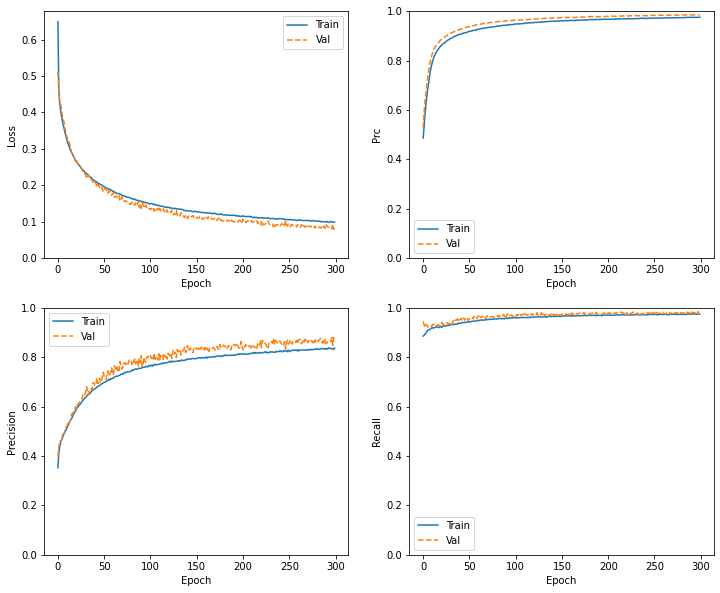

In [25]:
plot_history(weighted_history)

Lastly, we'll also train another model with the same architecture using oversampling as the imbalanced dataset technique. 

For this model, the oversampled dataset will be used.

In [26]:
oversampled_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

oversampled_history = oversampled_model.fit(
            x=resampled_X_train, 
            y=resampled_y_train, 
            validation_data=(resampled_X_val, resampled_y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
44/44 [==============================] - 1s 14ms/step - loss: 0.6075 - accuracy: 0.7954 - precision: 0.4966 - recall: 0.5774 - auc: 0.8489 - prc: 0.6693 - val_loss: 0.4006 - val_accuracy: 0.7966 - val_precision: 0.5704 - val_recall: 0.0903 - val_auc: 0.8071 - val_prc: 0.4327
Epoch 2/500
44/44 [==============================] - 0s 4ms/step - loss: 0.4009 - accurac

Epoch 27/500
44/44 [==============================] - 0s 4ms/step - loss: 0.2084 - accuracy: 0.9120 - precision: 0.8655 - recall: 0.6761 - auc: 0.9591 - prc: 0.8714 - val_loss: 0.2002 - val_accuracy: 0.9163 - val_precision: 0.8709 - val_recall: 0.7019 - val_auc: 0.9631 - val_prc: 0.8873
Epoch 28/500
44/44 [==============================] - 0s 4ms/step - loss: 0.2070 - accuracy: 0.9113 - precision: 0.8619 - recall: 0.6802 - auc: 0.9595 - prc: 0.8742 - val_loss: 0.1966 - val_accuracy: 0.9198 - val_precision: 0.8966 - val_recall: 0.6948 - val_auc: 0.9658 - val_prc: 0.8947
Epoch 29/500
44/44 [==============================] - 0s 5ms/step - loss: 0.2049 - accuracy: 0.9128 - precision: 0.8628 - recall: 0.6853 - auc: 0.9610 - prc: 0.8766 - val_loss: 0.1932 - val_accuracy: 0.9214 - val_precision: 0.8982 - val_recall: 0.7019 - val_auc: 0.9671 - val_prc: 0.8986
Epoch 30/500
44/44 [==============================] - 0s 5ms/step - loss: 0.2015 - accuracy: 0.9149 - precision: 0.8676 - recall: 0.6969

44/44 [==============================] - 0s 4ms/step - loss: 0.1612 - accuracy: 0.9370 - precision: 0.9004 - recall: 0.7812 - auc: 0.9766 - prc: 0.9216 - val_loss: 0.1483 - val_accuracy: 0.9464 - val_precision: 0.9236 - val_recall: 0.8092 - val_auc: 0.9811 - val_prc: 0.9398
Epoch 56/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1585 - accuracy: 0.9379 - precision: 0.9009 - recall: 0.7852 - auc: 0.9772 - prc: 0.9244 - val_loss: 0.1470 - val_accuracy: 0.9453 - val_precision: 0.9290 - val_recall: 0.7981 - val_auc: 0.9814 - val_prc: 0.9405
Epoch 57/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9367 - precision: 0.8959 - recall: 0.7860 - auc: 0.9769 - prc: 0.9243 - val_loss: 0.1458 - val_accuracy: 0.9473 - val_precision: 0.9268 - val_recall: 0.8107 - val_auc: 0.9818 - val_prc: 0.9418
Epoch 58/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1607 - accuracy: 0.9370 - precision: 0.8954 - recall: 0.7914 - auc: 0.976

44/44 [==============================] - 0s 4ms/step - loss: 0.1397 - accuracy: 0.9457 - precision: 0.9017 - recall: 0.8247 - auc: 0.9818 - prc: 0.9382 - val_loss: 0.1262 - val_accuracy: 0.9528 - val_precision: 0.9319 - val_recall: 0.8339 - val_auc: 0.9863 - val_prc: 0.9554
Epoch 84/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1383 - accuracy: 0.9448 - precision: 0.8999 - recall: 0.8291 - auc: 0.9827 - prc: 0.9430 - val_loss: 0.1249 - val_accuracy: 0.9533 - val_precision: 0.9329 - val_recall: 0.8355 - val_auc: 0.9867 - val_prc: 0.9568
Epoch 85/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1374 - accuracy: 0.9468 - precision: 0.9014 - recall: 0.8348 - auc: 0.9829 - prc: 0.9438 - val_loss: 0.1245 - val_accuracy: 0.9526 - val_precision: 0.9308 - val_recall: 0.8344 - val_auc: 0.9866 - val_prc: 0.9563
Epoch 86/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1393 - accuracy: 0.9455 - precision: 0.9045 - recall: 0.8271 - auc: 0.982

44/44 [==============================] - 0s 4ms/step - loss: 0.1246 - accuracy: 0.9502 - precision: 0.9039 - recall: 0.8493 - auc: 0.9859 - prc: 0.9532 - val_loss: 0.1106 - val_accuracy: 0.9579 - val_precision: 0.9304 - val_recall: 0.8622 - val_auc: 0.9893 - val_prc: 0.9652
Epoch 112/500
44/44 [==============================] - 0s 5ms/step - loss: 0.1217 - accuracy: 0.9510 - precision: 0.9058 - recall: 0.8504 - auc: 0.9862 - prc: 0.9545 - val_loss: 0.1105 - val_accuracy: 0.9586 - val_precision: 0.9236 - val_recall: 0.8732 - val_auc: 0.9896 - val_prc: 0.9658
Epoch 113/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.9527 - precision: 0.9103 - recall: 0.8553 - auc: 0.9868 - prc: 0.9554 - val_loss: 0.1102 - val_accuracy: 0.9571 - val_precision: 0.9349 - val_recall: 0.8534 - val_auc: 0.9893 - val_prc: 0.9654
Epoch 114/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1222 - accuracy: 0.9517 - precision: 0.9095 - recall: 0.8521 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.1119 - accuracy: 0.9558 - precision: 0.9138 - recall: 0.8677 - auc: 0.9883 - prc: 0.9618 - val_loss: 0.0996 - val_accuracy: 0.9629 - val_precision: 0.9247 - val_recall: 0.8947 - val_auc: 0.9913 - val_prc: 0.9715
Epoch 140/500
44/44 [==============================] - 0s 5ms/step - loss: 0.1116 - accuracy: 0.9552 - precision: 0.9087 - recall: 0.8711 - auc: 0.9884 - prc: 0.9619 - val_loss: 0.0994 - val_accuracy: 0.9631 - val_precision: 0.9271 - val_recall: 0.8929 - val_auc: 0.9914 - val_prc: 0.9717
Epoch 141/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.9552 - precision: 0.9071 - recall: 0.8715 - auc: 0.9883 - prc: 0.9602 - val_loss: 0.0983 - val_accuracy: 0.9626 - val_precision: 0.9398 - val_recall: 0.8763 - val_auc: 0.9917 - val_prc: 0.9726
Epoch 142/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1122 - accuracy: 0.9557 - precision: 0.9140 - recall: 0.8674 - auc: 0.

44/44 [==============================] - 0s 5ms/step - loss: 0.1061 - accuracy: 0.9573 - precision: 0.9138 - recall: 0.8788 - auc: 0.9896 - prc: 0.9653 - val_loss: 0.0909 - val_accuracy: 0.9655 - val_precision: 0.9309 - val_recall: 0.9011 - val_auc: 0.9927 - val_prc: 0.9760
Epoch 168/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1023 - accuracy: 0.9591 - precision: 0.9151 - recall: 0.8831 - auc: 0.9903 - prc: 0.9672 - val_loss: 0.0909 - val_accuracy: 0.9654 - val_precision: 0.9469 - val_recall: 0.8830 - val_auc: 0.9928 - val_prc: 0.9765
Epoch 169/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1047 - accuracy: 0.9587 - precision: 0.9171 - recall: 0.8787 - auc: 0.9896 - prc: 0.9659 - val_loss: 0.0901 - val_accuracy: 0.9655 - val_precision: 0.9401 - val_recall: 0.8909 - val_auc: 0.9929 - val_prc: 0.9765
Epoch 170/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1041 - accuracy: 0.9583 - precision: 0.9153 - recall: 0.8781 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0985 - accuracy: 0.9612 - precision: 0.9203 - recall: 0.8899 - auc: 0.9908 - prc: 0.9700 - val_loss: 0.0844 - val_accuracy: 0.9671 - val_precision: 0.9424 - val_recall: 0.8966 - val_auc: 0.9937 - val_prc: 0.9791
Epoch 196/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0974 - accuracy: 0.9613 - precision: 0.9199 - recall: 0.8890 - auc: 0.9909 - prc: 0.9698 - val_loss: 0.0838 - val_accuracy: 0.9672 - val_precision: 0.9418 - val_recall: 0.8977 - val_auc: 0.9939 - val_prc: 0.9796
Epoch 197/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0984 - accuracy: 0.9614 - precision: 0.9199 - recall: 0.8918 - auc: 0.9910 - prc: 0.9702 - val_loss: 0.0847 - val_accuracy: 0.9663 - val_precision: 0.9489 - val_recall: 0.8856 - val_auc: 0.9938 - val_prc: 0.9794
Epoch 198/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1000 - accuracy: 0.9599 - precision: 0.9184 - recall: 0.8845 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9622 - precision: 0.9222 - recall: 0.8918 - auc: 0.9916 - prc: 0.9728 - val_loss: 0.0797 - val_accuracy: 0.9683 - val_precision: 0.9522 - val_recall: 0.8927 - val_auc: 0.9945 - val_prc: 0.9819
Epoch 224/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0952 - accuracy: 0.9617 - precision: 0.9215 - recall: 0.8909 - auc: 0.9914 - prc: 0.9713 - val_loss: 0.0796 - val_accuracy: 0.9692 - val_precision: 0.9422 - val_recall: 0.9075 - val_auc: 0.9945 - val_prc: 0.9816
Epoch 225/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0918 - accuracy: 0.9630 - precision: 0.9202 - recall: 0.8978 - auc: 0.9920 - prc: 0.9733 - val_loss: 0.0797 - val_accuracy: 0.9688 - val_precision: 0.9411 - val_recall: 0.9068 - val_auc: 0.9944 - val_prc: 0.9814
Epoch 226/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0921 - accuracy: 0.9633 - precision: 0.9244 - recall: 0.8939 - auc: 0.

44/44 [==============================] - 0s 5ms/step - loss: 0.0900 - accuracy: 0.9633 - precision: 0.9237 - recall: 0.8976 - auc: 0.9923 - prc: 0.9752 - val_loss: 0.0752 - val_accuracy: 0.9694 - val_precision: 0.9365 - val_recall: 0.9148 - val_auc: 0.9949 - val_prc: 0.9834
Epoch 252/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9651 - precision: 0.9267 - recall: 0.9010 - auc: 0.9926 - prc: 0.9757 - val_loss: 0.0753 - val_accuracy: 0.9703 - val_precision: 0.9354 - val_recall: 0.9209 - val_auc: 0.9949 - val_prc: 0.9834
Epoch 253/500
44/44 [==============================] - 0s 5ms/step - loss: 0.0873 - accuracy: 0.9652 - precision: 0.9235 - recall: 0.9070 - auc: 0.9928 - prc: 0.9762 - val_loss: 0.0753 - val_accuracy: 0.9688 - val_precision: 0.9491 - val_recall: 0.8982 - val_auc: 0.9950 - val_prc: 0.9837
Epoch 254/500
44/44 [==============================] - 0s 5ms/step - loss: 0.0887 - accuracy: 0.9638 - precision: 0.9243 - recall: 0.8977 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0882 - accuracy: 0.9637 - precision: 0.9225 - recall: 0.9021 - auc: 0.9926 - prc: 0.9758 - val_loss: 0.0717 - val_accuracy: 0.9704 - val_precision: 0.9384 - val_recall: 0.9181 - val_auc: 0.9953 - val_prc: 0.9846
Epoch 280/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0852 - accuracy: 0.9656 - precision: 0.9242 - recall: 0.9074 - auc: 0.9930 - prc: 0.9766 - val_loss: 0.0716 - val_accuracy: 0.9719 - val_precision: 0.9514 - val_recall: 0.9117 - val_auc: 0.9954 - val_prc: 0.9852
Epoch 281/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9649 - precision: 0.9284 - recall: 0.8988 - auc: 0.9929 - prc: 0.9761 - val_loss: 0.0710 - val_accuracy: 0.9719 - val_precision: 0.9436 - val_recall: 0.9198 - val_auc: 0.9955 - val_prc: 0.9853
Epoch 282/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0846 - accuracy: 0.9668 - precision: 0.9302 - recall: 0.9086 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0830 - accuracy: 0.9674 - precision: 0.9303 - recall: 0.9099 - auc: 0.9935 - prc: 0.9785 - val_loss: 0.0692 - val_accuracy: 0.9726 - val_precision: 0.9499 - val_recall: 0.9167 - val_auc: 0.9956 - val_prc: 0.9858
Epoch 308/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9678 - precision: 0.9355 - recall: 0.9065 - auc: 0.9936 - prc: 0.9792 - val_loss: 0.0691 - val_accuracy: 0.9725 - val_precision: 0.9488 - val_recall: 0.9172 - val_auc: 0.9956 - val_prc: 0.9858
Epoch 309/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9665 - precision: 0.9266 - recall: 0.9110 - auc: 0.9937 - prc: 0.9788 - val_loss: 0.0688 - val_accuracy: 0.9721 - val_precision: 0.9479 - val_recall: 0.9163 - val_auc: 0.9956 - val_prc: 0.9860
Epoch 310/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0827 - accuracy: 0.9673 - precision: 0.9277 - recall: 0.9116 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9673 - precision: 0.9311 - recall: 0.9103 - auc: 0.9937 - prc: 0.9798 - val_loss: 0.0668 - val_accuracy: 0.9727 - val_precision: 0.9551 - val_recall: 0.9117 - val_auc: 0.9959 - val_prc: 0.9869
Epoch 336/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0801 - accuracy: 0.9671 - precision: 0.9329 - recall: 0.9053 - auc: 0.9940 - prc: 0.9795 - val_loss: 0.0661 - val_accuracy: 0.9744 - val_precision: 0.9439 - val_recall: 0.9324 - val_auc: 0.9960 - val_prc: 0.9871
Epoch 337/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9683 - precision: 0.9293 - recall: 0.9167 - auc: 0.9942 - prc: 0.9802 - val_loss: 0.0664 - val_accuracy: 0.9728 - val_precision: 0.9477 - val_recall: 0.9203 - val_auc: 0.9959 - val_prc: 0.9871
Epoch 338/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0796 - accuracy: 0.9685 - precision: 0.9311 - recall: 0.9163 - auc: 0.

Training history of the oversampled model looks quite ok but recall learning seems to be a bit on the lower edge.

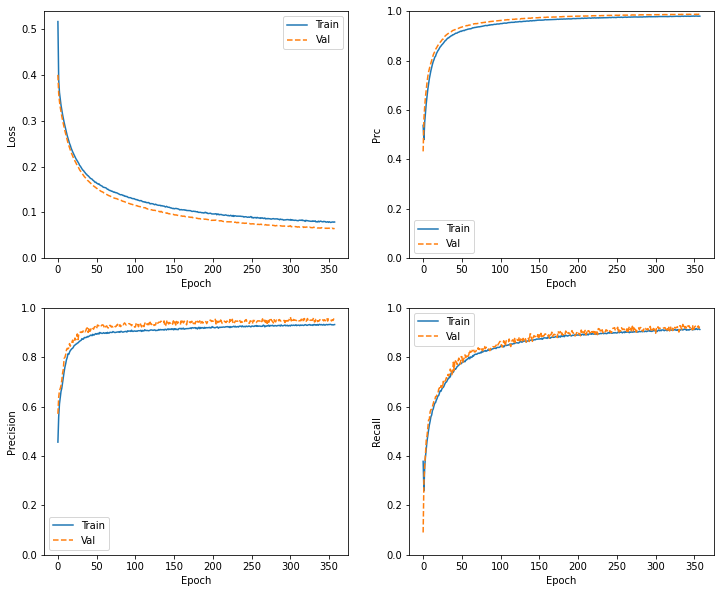

In [27]:
plot_history(oversampled_history)

Finally, let's compare information and performance of the Kinect Cut Start models by defining functions for plotting the confusion matrix and ROC. 
We'll also print the evaluation metrics.

In [28]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

In [29]:
from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

--- BASELINE MODEL ---
loss :  0.06432083994150162
accuracy :  0.9739297032356262
precision :  0.9578557014465332
recall :  0.9135048389434814
auc :  0.9959064722061157
prc :  0.9876654148101807



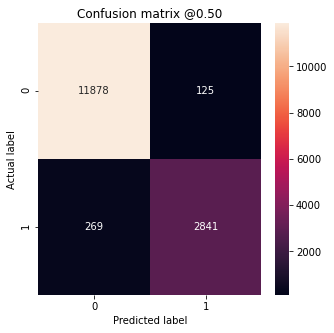


--- MODEL WITH CLASS WEIGHTS ---
loss :  0.08302032947540283
accuracy :  0.9653940200805664
precision :  0.8701001405715942
recall :  0.9778134822845459
auc :  0.9957996606826782
prc :  0.9838333129882812



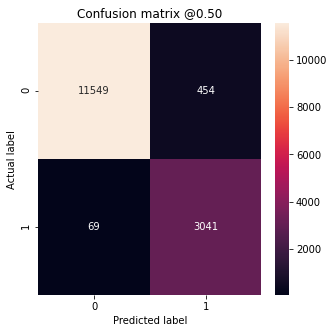


--- OVERSAMPLED MODEL ---
loss :  0.10981343686580658
accuracy :  0.9523253440856934
precision :  0.9895429611206055
recall :  0.914445161819458
auc :  0.9967066645622253
prc :  0.9968034029006958



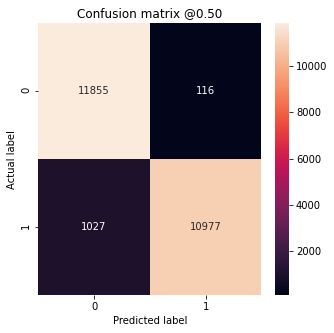

In [30]:
import seaborn as sns

baseline_predictions = baseline_model.predict(X_test)
weighted_predictions = weighted_model.predict(X_test)
oversampled_predictions = oversampled_model.predict(resampled_X_test)

baseline_results = baseline_model.evaluate(X_test, 
                                          y_test,
                                          batch_size=BATCH_SIZE, 
                                          verbose=0)
weighted_results = weighted_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=BATCH_SIZE, 
                                              verbose=0)
oversampled_results = oversampled_model.evaluate(resampled_X_test, 
                                                resampled_y_test,
                                                batch_size=BATCH_SIZE, 
                                                verbose=0)

print('--- BASELINE MODEL ---')
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, baseline_predictions) 
print('')

print('--- MODEL WITH CLASS WEIGHTS ---')
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, weighted_predictions) 
print('')

print('--- OVERSAMPLED MODEL ---')
for name, value in zip(oversampled_model.metrics_names, oversampled_results):
  print(name, ': ', value)
print('')
plot_cm(resampled_y_test, oversampled_predictions) 

From the results of metrics values, confusion matrices, and ROC curves, we can draw the following conclusions:

- The baseline model had the highest accuracy and it also showed the best ROC performance where its blue line covered the most surface below the curve. However, it seems to be performing better on the training set than the test set so that might be a sign of overfitting?
- As for the imbalanced dataset techniques, they seemed to have different affects on the models. For class weight, the model has a lot of false positives (which gives a lower precision) which means it incorrectly predictions normal frames to be start frames as well. 
- For the oversampled model, we have the opposite situation with a lower recall value and more false negatives which means that it misses start frames.

For now, the baseline model without imbalanced techniques seems to be the best choice.
But we will look at the Kinect stop frames next.

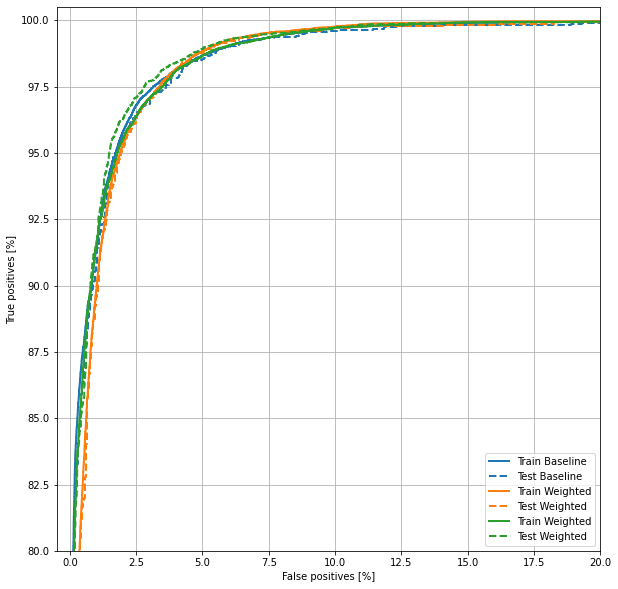

In [31]:
train_baseline_predictions = baseline_model.predict(X_train)
train_weighted_predictions = weighted_model.predict(X_train)
train_oversampled_predictions = oversampled_model.predict(resampled_X_train)

plot_roc("Train Baseline", y_train, train_baseline_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_weighted_predictions, color=colors[1])
plot_roc("Test Weighted", y_test, weighted_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", resampled_y_train, train_oversampled_predictions, color=colors[2])
plot_roc("Test Weighted", resampled_y_test, oversampled_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

### 2.1.2 Kinect Cut Stop model

We have worked in [cut_stop_kinect.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment13/cut_stop_kinect.ipynb) when experimenting with 3 versions of this model, and the experiment results are saved in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=[%22550767846e1441389ca2c312d5b73355%22,%22ef3c445b97af4119bcd587a6e0bd4fcd%22,%229528dd609c584bea9f6d98346291287a%22]&experiment=0) for easy comparison. We did not have to experiment as much with this model as it worked very similar to cutting start frames from the same Kinect data.

We do not have to load the dataset again, but we do need to recreate the X and y sets because before, we dropped the "end" column and kept the "start" column, but now we have to do the reversed situation.

In [32]:
X = df.drop(columns=['end', 'start'])
y = df['end']
y = y.astype(int)

X, y = shuffle(X, y)

In [33]:
random_state = 42
np.random.seed(random_state)

sm = SMOTE(random_state=random_state)
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

(245960, 39)
(245960,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [35]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=random_state)
resampled_X_train, resampled_X_val, resampled_y_train, resampled_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

resampled_scaler = StandardScaler()
resampled_X_train = resampled_scaler.fit_transform(resampled_X_train)

resampled_X_val = resampled_scaler.transform(resampled_X_val)
resampled_X_test = resampled_scaler.transform(resampled_X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (108812,)
Validation labels shape: (27203,)
Test labels shape: (15113,) 

Training features shape: (108812, 39)
Validation features shape: (27203, 39)
Test features shape: (15113, 39)


And then we begin the experimentation with the baseline model, followed by the weighted model, and lastly the oversampled model - all for cutting Kinect stop frames.

And we see from its learning history that the recall value seems to be low.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 2s 13ms/step - loss: 0.5960 - accuracy: 0.7970 - precision: 0.6357 - recall: 0.7077 - auc: 0.8604 - prc: 0.8007 - val_loss: 0.3354 - val_accuracy: 0.8706 - val_precision: 0.9636 - val_recall: 0.3112 - val_auc: 0.8227 - val_prc: 0.6204
Epoch 2/500
55/55 [==============================] - 0s 4ms/step - loss: 0.3483 - accurac

Epoch 27/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1909 - accuracy: 0.9276 - precision: 0.9092 - recall: 0.6824 - auc: 0.9565 - prc: 0.8849 - val_loss: 0.1783 - val_accuracy: 0.9329 - val_precision: 0.9389 - val_recall: 0.6814 - val_auc: 0.9638 - val_prc: 0.9029
Epoch 28/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1884 - accuracy: 0.9285 - precision: 0.9086 - recall: 0.6876 - auc: 0.9577 - prc: 0.8880 - val_loss: 0.1759 - val_accuracy: 0.9326 - val_precision: 0.9458 - val_recall: 0.6736 - val_auc: 0.9659 - val_prc: 0.9069
Epoch 29/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1881 - accuracy: 0.9280 - precision: 0.9079 - recall: 0.6867 - auc: 0.9579 - prc: 0.8883 - val_loss: 0.1734 - val_accuracy: 0.9350 - val_precision: 0.9381 - val_recall: 0.6941 - val_auc: 0.9659 - val_prc: 0.9079
Epoch 30/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.9276 - precision: 0.9006 - recall: 0.6898

55/55 [==============================] - 0s 4ms/step - loss: 0.1488 - accuracy: 0.9442 - precision: 0.9204 - recall: 0.7673 - auc: 0.9729 - prc: 0.9262 - val_loss: 0.1345 - val_accuracy: 0.9497 - val_precision: 0.9563 - val_recall: 0.7624 - val_auc: 0.9790 - val_prc: 0.9413
Epoch 56/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1487 - accuracy: 0.9431 - precision: 0.9163 - recall: 0.7668 - auc: 0.9732 - prc: 0.9268 - val_loss: 0.1336 - val_accuracy: 0.9493 - val_precision: 0.9655 - val_recall: 0.7524 - val_auc: 0.9792 - val_prc: 0.9423
Epoch 57/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1462 - accuracy: 0.9447 - precision: 0.9229 - recall: 0.7667 - auc: 0.9739 - prc: 0.9278 - val_loss: 0.1320 - val_accuracy: 0.9512 - val_precision: 0.9512 - val_recall: 0.7757 - val_auc: 0.9798 - val_prc: 0.9432
Epoch 58/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1460 - accuracy: 0.9447 - precision: 0.9210 - recall: 0.7704 - auc: 0.974

55/55 [==============================] - 0s 4ms/step - loss: 0.1268 - accuracy: 0.9507 - precision: 0.9241 - recall: 0.8027 - auc: 0.9806 - prc: 0.9439 - val_loss: 0.1129 - val_accuracy: 0.9582 - val_precision: 0.9587 - val_recall: 0.8084 - val_auc: 0.9852 - val_prc: 0.9568
Epoch 84/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1256 - accuracy: 0.9517 - precision: 0.9274 - recall: 0.8050 - auc: 0.9808 - prc: 0.9456 - val_loss: 0.1119 - val_accuracy: 0.9580 - val_precision: 0.9584 - val_recall: 0.8076 - val_auc: 0.9856 - val_prc: 0.9572
Epoch 85/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1270 - accuracy: 0.9505 - precision: 0.9202 - recall: 0.8055 - auc: 0.9807 - prc: 0.9441 - val_loss: 0.1116 - val_accuracy: 0.9571 - val_precision: 0.9567 - val_recall: 0.8040 - val_auc: 0.9856 - val_prc: 0.9576
Epoch 86/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1256 - accuracy: 0.9521 - precision: 0.9262 - recall: 0.8069 - auc: 0.981

55/55 [==============================] - 0s 4ms/step - loss: 0.1147 - accuracy: 0.9551 - precision: 0.9309 - recall: 0.8215 - auc: 0.9844 - prc: 0.9539 - val_loss: 0.0983 - val_accuracy: 0.9632 - val_precision: 0.9513 - val_recall: 0.8440 - val_auc: 0.9892 - val_prc: 0.9668
Epoch 112/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1125 - accuracy: 0.9566 - precision: 0.9297 - recall: 0.8298 - auc: 0.9846 - prc: 0.9555 - val_loss: 0.0979 - val_accuracy: 0.9623 - val_precision: 0.9585 - val_recall: 0.8318 - val_auc: 0.9894 - val_prc: 0.9673
Epoch 113/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1126 - accuracy: 0.9567 - precision: 0.9321 - recall: 0.8271 - auc: 0.9846 - prc: 0.9548 - val_loss: 0.0984 - val_accuracy: 0.9624 - val_precision: 0.9581 - val_recall: 0.8328 - val_auc: 0.9891 - val_prc: 0.9664
Epoch 114/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1110 - accuracy: 0.9569 - precision: 0.9325 - recall: 0.8294 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1036 - accuracy: 0.9593 - precision: 0.9327 - recall: 0.8419 - auc: 0.9870 - prc: 0.9609 - val_loss: 0.0885 - val_accuracy: 0.9662 - val_precision: 0.9546 - val_recall: 0.8577 - val_auc: 0.9912 - val_prc: 0.9723
Epoch 140/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1046 - accuracy: 0.9592 - precision: 0.9314 - recall: 0.8460 - auc: 0.9866 - prc: 0.9614 - val_loss: 0.0884 - val_accuracy: 0.9660 - val_precision: 0.9566 - val_recall: 0.8547 - val_auc: 0.9914 - val_prc: 0.9726
Epoch 141/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1032 - accuracy: 0.9597 - precision: 0.9314 - recall: 0.8465 - auc: 0.9871 - prc: 0.9612 - val_loss: 0.0878 - val_accuracy: 0.9658 - val_precision: 0.9590 - val_recall: 0.8513 - val_auc: 0.9916 - val_prc: 0.9729
Epoch 142/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1015 - accuracy: 0.9601 - precision: 0.9350 - recall: 0.8479 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0947 - accuracy: 0.9630 - precision: 0.9393 - recall: 0.8554 - auc: 0.9890 - prc: 0.9665 - val_loss: 0.0797 - val_accuracy: 0.9698 - val_precision: 0.9577 - val_recall: 0.8750 - val_auc: 0.9932 - val_prc: 0.9775
Epoch 168/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0967 - accuracy: 0.9619 - precision: 0.9355 - recall: 0.8574 - auc: 0.9892 - prc: 0.9660 - val_loss: 0.0798 - val_accuracy: 0.9702 - val_precision: 0.9559 - val_recall: 0.8790 - val_auc: 0.9933 - val_prc: 0.9774
Epoch 169/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0958 - accuracy: 0.9627 - precision: 0.9325 - recall: 0.8620 - auc: 0.9892 - prc: 0.9664 - val_loss: 0.0801 - val_accuracy: 0.9703 - val_precision: 0.9503 - val_recall: 0.8858 - val_auc: 0.9933 - val_prc: 0.9772
Epoch 170/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.9634 - precision: 0.9357 - recall: 0.8613 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0906 - accuracy: 0.9656 - precision: 0.9384 - recall: 0.8718 - auc: 0.9895 - prc: 0.9694 - val_loss: 0.0743 - val_accuracy: 0.9718 - val_precision: 0.9580 - val_recall: 0.8862 - val_auc: 0.9941 - val_prc: 0.9801
Epoch 196/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0905 - accuracy: 0.9657 - precision: 0.9396 - recall: 0.8720 - auc: 0.9898 - prc: 0.9695 - val_loss: 0.0741 - val_accuracy: 0.9721 - val_precision: 0.9603 - val_recall: 0.8856 - val_auc: 0.9943 - val_prc: 0.9806
Epoch 197/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.9663 - precision: 0.9409 - recall: 0.8748 - auc: 0.9901 - prc: 0.9699 - val_loss: 0.0737 - val_accuracy: 0.9717 - val_precision: 0.9614 - val_recall: 0.8820 - val_auc: 0.9944 - val_prc: 0.9805
Epoch 198/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9655 - precision: 0.9377 - recall: 0.8725 - auc: 0.

55/55 [==============================] - 0s 5ms/step - loss: 0.0846 - accuracy: 0.9681 - precision: 0.9448 - recall: 0.8798 - auc: 0.9909 - prc: 0.9727 - val_loss: 0.0701 - val_accuracy: 0.9733 - val_precision: 0.9686 - val_recall: 0.8844 - val_auc: 0.9950 - val_prc: 0.9827
Epoch 224/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9676 - precision: 0.9429 - recall: 0.8801 - auc: 0.9908 - prc: 0.9725 - val_loss: 0.0696 - val_accuracy: 0.9747 - val_precision: 0.9551 - val_recall: 0.9059 - val_auc: 0.9951 - val_prc: 0.9830
Epoch 225/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9670 - precision: 0.9381 - recall: 0.8828 - auc: 0.9904 - prc: 0.9712 - val_loss: 0.0701 - val_accuracy: 0.9733 - val_precision: 0.9715 - val_recall: 0.8814 - val_auc: 0.9951 - val_prc: 0.9830
Epoch 226/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9675 - precision: 0.9414 - recall: 0.8800 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9689 - precision: 0.9430 - recall: 0.8851 - auc: 0.9917 - prc: 0.9738 - val_loss: 0.0661 - val_accuracy: 0.9753 - val_precision: 0.9644 - val_recall: 0.8995 - val_auc: 0.9955 - val_prc: 0.9846
Epoch 252/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9684 - precision: 0.9400 - recall: 0.8868 - auc: 0.9918 - prc: 0.9742 - val_loss: 0.0662 - val_accuracy: 0.9754 - val_precision: 0.9482 - val_recall: 0.9172 - val_auc: 0.9956 - val_prc: 0.9844
Epoch 253/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0832 - accuracy: 0.9681 - precision: 0.9365 - recall: 0.8898 - auc: 0.9915 - prc: 0.9737 - val_loss: 0.0661 - val_accuracy: 0.9750 - val_precision: 0.9571 - val_recall: 0.9051 - val_auc: 0.9955 - val_prc: 0.9841
Epoch 254/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0807 - accuracy: 0.9697 - precision: 0.9453 - recall: 0.8898 - auc: 0.

55/55 [==============================] - 0s 5ms/step - loss: 0.0788 - accuracy: 0.9699 - precision: 0.9430 - recall: 0.8933 - auc: 0.9922 - prc: 0.9763 - val_loss: 0.0632 - val_accuracy: 0.9758 - val_precision: 0.9721 - val_recall: 0.8945 - val_auc: 0.9960 - val_prc: 0.9860
Epoch 280/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0793 - accuracy: 0.9698 - precision: 0.9442 - recall: 0.8913 - auc: 0.9924 - prc: 0.9760 - val_loss: 0.0634 - val_accuracy: 0.9764 - val_precision: 0.9615 - val_recall: 0.9087 - val_auc: 0.9960 - val_prc: 0.9855
Epoch 281/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9696 - precision: 0.9406 - recall: 0.8938 - auc: 0.9916 - prc: 0.9751 - val_loss: 0.0639 - val_accuracy: 0.9751 - val_precision: 0.9722 - val_recall: 0.8905 - val_auc: 0.9959 - val_prc: 0.9858
Epoch 282/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0775 - accuracy: 0.9711 - precision: 0.9478 - recall: 0.8935 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0753 - accuracy: 0.9713 - precision: 0.9422 - recall: 0.9017 - auc: 0.9929 - prc: 0.9781 - val_loss: 0.0602 - val_accuracy: 0.9769 - val_precision: 0.9695 - val_recall: 0.9033 - val_auc: 0.9962 - val_prc: 0.9869
Epoch 308/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 0.9719 - precision: 0.9471 - recall: 0.9000 - auc: 0.9926 - prc: 0.9782 - val_loss: 0.0603 - val_accuracy: 0.9776 - val_precision: 0.9670 - val_recall: 0.9099 - val_auc: 0.9962 - val_prc: 0.9867
Epoch 309/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9716 - precision: 0.9454 - recall: 0.8996 - auc: 0.9926 - prc: 0.9777 - val_loss: 0.0603 - val_accuracy: 0.9774 - val_precision: 0.9613 - val_recall: 0.9142 - val_auc: 0.9964 - val_prc: 0.9869
Epoch 310/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9719 - precision: 0.9467 - recall: 0.9016 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0734 - accuracy: 0.9716 - precision: 0.9467 - recall: 0.8995 - auc: 0.9937 - prc: 0.9794 - val_loss: 0.0579 - val_accuracy: 0.9786 - val_precision: 0.9614 - val_recall: 0.9210 - val_auc: 0.9967 - val_prc: 0.9880
Epoch 336/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9720 - precision: 0.9468 - recall: 0.9030 - auc: 0.9934 - prc: 0.9798 - val_loss: 0.0585 - val_accuracy: 0.9771 - val_precision: 0.9703 - val_recall: 0.9037 - val_auc: 0.9966 - val_prc: 0.9880
Epoch 337/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.9723 - precision: 0.9493 - recall: 0.9005 - auc: 0.9936 - prc: 0.9800 - val_loss: 0.0578 - val_accuracy: 0.9778 - val_precision: 0.9724 - val_recall: 0.9057 - val_auc: 0.9967 - val_prc: 0.9881
Epoch 338/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0721 - accuracy: 0.9724 - precision: 0.9501 - recall: 0.9009 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.0719 - accuracy: 0.9727 - precision: 0.9505 - recall: 0.9019 - auc: 0.9937 - prc: 0.9801 - val_loss: 0.0564 - val_accuracy: 0.9792 - val_precision: 0.9596 - val_recall: 0.9266 - val_auc: 0.9969 - val_prc: 0.9886
Epoch 364/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0726 - accuracy: 0.9728 - precision: 0.9487 - recall: 0.9029 - auc: 0.9936 - prc: 0.9791 - val_loss: 0.0565 - val_accuracy: 0.9774 - val_precision: 0.9736 - val_recall: 0.9023 - val_auc: 0.9970 - val_prc: 0.9890
Epoch 365/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9716 - precision: 0.9484 - recall: 0.8969 - auc: 0.9935 - prc: 0.9792 - val_loss: 0.0571 - val_accuracy: 0.9772 - val_precision: 0.9699 - val_recall: 0.9045 - val_auc: 0.9969 - val_prc: 0.9884
Epoch 366/500
55/55 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.9723 - precision: 0.9491 - recall: 0.9011 - auc: 0.

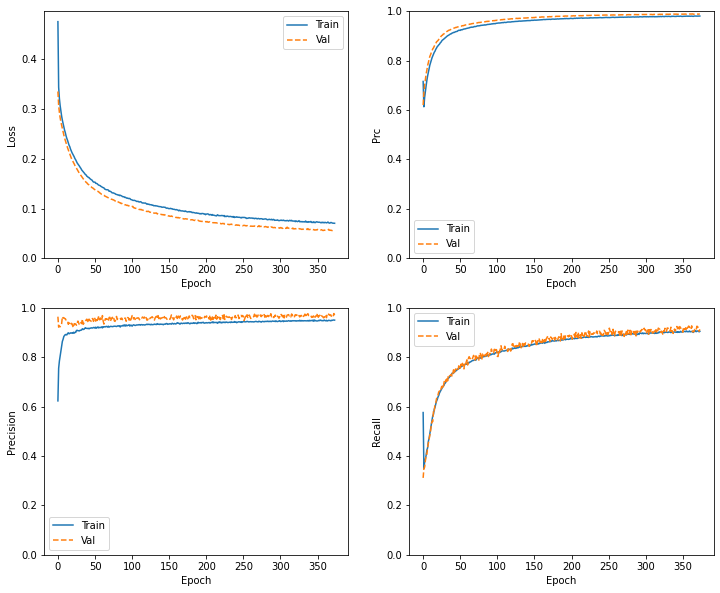

In [37]:
baseline_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

baseline_history = baseline_model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(baseline_history)

Moving on to the weigted model.<br />
We can see that we have similar class weights for stop frames as we had for start frames.

In [38]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for normal frames:', class_weights[0])
print('Weight for stop frames:', class_weights[1])

Weight for normal frames: 0.6148543272382072
Weight for stop frames: 2.6766702745252386


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 1s 11ms/step - loss: 0.7161 - accuracy: 0.7766 - precision: 0.4530 - recall: 0.6654 - auc: 0.8383 - prc: 0.6749 - val_loss: 0.4832 - val_accuracy: 0.7189 - val_precision: 0.3756 - val_recall: 0.7877 - val_auc: 0.8451 - val_prc: 0.6377
Epoch 2/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4719 - accurac

Epoch 27/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2576 - accuracy: 0.8887 - precision: 0.6458 - recall: 0.8957 - auc: 0.9623 - prc: 0.8872 - val_loss: 0.2343 - val_accuracy: 0.9131 - val_precision: 0.7085 - val_recall: 0.8995 - val_auc: 0.9693 - val_prc: 0.9082
Epoch 28/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2585 - accuracy: 0.8898 - precision: 0.6508 - recall: 0.8967 - auc: 0.9619 - prc: 0.8891 - val_loss: 0.2273 - val_accuracy: 0.9177 - val_precision: 0.7237 - val_recall: 0.8967 - val_auc: 0.9701 - val_prc: 0.9097
Epoch 29/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2510 - accuracy: 0.8918 - precision: 0.6549 - recall: 0.8956 - auc: 0.9638 - prc: 0.8921 - val_loss: 0.2424 - val_accuracy: 0.9039 - val_precision: 0.6772 - val_recall: 0.9168 - val_auc: 0.9709 - val_prc: 0.9111
Epoch 30/500
55/55 [==============================] - 0s 4ms/step - loss: 0.2518 - accuracy: 0.8901 - precision: 0.6506 - recall: 0.8987

55/55 [==============================] - 0s 4ms/step - loss: 0.1995 - accuracy: 0.9143 - precision: 0.7096 - recall: 0.9180 - auc: 0.9768 - prc: 0.9261 - val_loss: 0.1743 - val_accuracy: 0.9305 - val_precision: 0.7563 - val_recall: 0.9206 - val_auc: 0.9823 - val_prc: 0.9428
Epoch 56/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1990 - accuracy: 0.9178 - precision: 0.7200 - recall: 0.9190 - auc: 0.9771 - prc: 0.9274 - val_loss: 0.1865 - val_accuracy: 0.9246 - val_precision: 0.7312 - val_recall: 0.9363 - val_auc: 0.9827 - val_prc: 0.9432
Epoch 57/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1975 - accuracy: 0.9157 - precision: 0.7142 - recall: 0.9200 - auc: 0.9774 - prc: 0.9277 - val_loss: 0.1733 - val_accuracy: 0.9321 - val_precision: 0.7588 - val_recall: 0.9270 - val_auc: 0.9833 - val_prc: 0.9455
Epoch 58/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1984 - accuracy: 0.9157 - precision: 0.7123 - recall: 0.9194 - auc: 0.976

55/55 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.9272 - precision: 0.7465 - recall: 0.9330 - auc: 0.9828 - prc: 0.9432 - val_loss: 0.1451 - val_accuracy: 0.9407 - val_precision: 0.7866 - val_recall: 0.9321 - val_auc: 0.9877 - val_prc: 0.9584
Epoch 84/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9301 - precision: 0.7504 - recall: 0.9287 - auc: 0.9831 - prc: 0.9438 - val_loss: 0.1579 - val_accuracy: 0.9334 - val_precision: 0.7549 - val_recall: 0.9471 - val_auc: 0.9878 - val_prc: 0.9585
Epoch 85/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1699 - accuracy: 0.9269 - precision: 0.7416 - recall: 0.9347 - auc: 0.9830 - prc: 0.9446 - val_loss: 0.1464 - val_accuracy: 0.9402 - val_precision: 0.7828 - val_recall: 0.9361 - val_auc: 0.9880 - val_prc: 0.9589
Epoch 86/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1668 - accuracy: 0.9298 - precision: 0.7503 - recall: 0.9338 - auc: 0.983

55/55 [==============================] - 0s 4ms/step - loss: 0.1537 - accuracy: 0.9362 - precision: 0.7701 - recall: 0.9419 - auc: 0.9861 - prc: 0.9529 - val_loss: 0.1324 - val_accuracy: 0.9439 - val_precision: 0.7915 - val_recall: 0.9457 - val_auc: 0.9906 - val_prc: 0.9663
Epoch 112/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1530 - accuracy: 0.9344 - precision: 0.7646 - recall: 0.9408 - auc: 0.9861 - prc: 0.9536 - val_loss: 0.1328 - val_accuracy: 0.9448 - val_precision: 0.7936 - val_recall: 0.9479 - val_auc: 0.9905 - val_prc: 0.9668
Epoch 113/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1524 - accuracy: 0.9346 - precision: 0.7659 - recall: 0.9421 - auc: 0.9863 - prc: 0.9531 - val_loss: 0.1351 - val_accuracy: 0.9419 - val_precision: 0.7823 - val_recall: 0.9497 - val_auc: 0.9906 - val_prc: 0.9668
Epoch 114/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1514 - accuracy: 0.9362 - precision: 0.7667 - recall: 0.9426 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1447 - accuracy: 0.9381 - precision: 0.7761 - recall: 0.9421 - auc: 0.9875 - prc: 0.9567 - val_loss: 0.1147 - val_accuracy: 0.9537 - val_precision: 0.8267 - val_recall: 0.9483 - val_auc: 0.9925 - val_prc: 0.9720
Epoch 140/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1409 - accuracy: 0.9399 - precision: 0.7800 - recall: 0.9451 - auc: 0.9881 - prc: 0.9581 - val_loss: 0.1227 - val_accuracy: 0.9492 - val_precision: 0.8043 - val_recall: 0.9578 - val_auc: 0.9924 - val_prc: 0.9718
Epoch 141/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1400 - accuracy: 0.9402 - precision: 0.7793 - recall: 0.9484 - auc: 0.9882 - prc: 0.9583 - val_loss: 0.1192 - val_accuracy: 0.9506 - val_precision: 0.8119 - val_recall: 0.9536 - val_auc: 0.9924 - val_prc: 0.9717
Epoch 142/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1394 - accuracy: 0.9402 - precision: 0.7795 - recall: 0.9479 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1290 - accuracy: 0.9441 - precision: 0.7888 - recall: 0.9534 - auc: 0.9899 - prc: 0.9635 - val_loss: 0.1140 - val_accuracy: 0.9527 - val_precision: 0.8157 - val_recall: 0.9612 - val_auc: 0.9934 - val_prc: 0.9751
Epoch 168/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9447 - precision: 0.7932 - recall: 0.9512 - auc: 0.9898 - prc: 0.9638 - val_loss: 0.1226 - val_accuracy: 0.9485 - val_precision: 0.7960 - val_recall: 0.9700 - val_auc: 0.9935 - val_prc: 0.9750
Epoch 169/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1323 - accuracy: 0.9429 - precision: 0.7877 - recall: 0.9539 - auc: 0.9895 - prc: 0.9633 - val_loss: 0.1081 - val_accuracy: 0.9567 - val_precision: 0.8339 - val_recall: 0.9558 - val_auc: 0.9935 - val_prc: 0.9753
Epoch 170/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1254 - accuracy: 0.9462 - precision: 0.7977 - recall: 0.9545 - auc: 0.

55/55 [==============================] - 0s 4ms/step - loss: 0.1227 - accuracy: 0.9472 - precision: 0.7996 - recall: 0.9544 - auc: 0.9909 - prc: 0.9665 - val_loss: 0.1102 - val_accuracy: 0.9552 - val_precision: 0.8223 - val_recall: 0.9662 - val_auc: 0.9941 - val_prc: 0.9760
Epoch 196/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1235 - accuracy: 0.9466 - precision: 0.7972 - recall: 0.9547 - auc: 0.9907 - prc: 0.9655 - val_loss: 0.1005 - val_accuracy: 0.9597 - val_precision: 0.8451 - val_recall: 0.9574 - val_auc: 0.9943 - val_prc: 0.9778
Epoch 197/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1244 - accuracy: 0.9481 - precision: 0.8055 - recall: 0.9541 - auc: 0.9907 - prc: 0.9668 - val_loss: 0.1026 - val_accuracy: 0.9588 - val_precision: 0.8391 - val_recall: 0.9610 - val_auc: 0.9944 - val_prc: 0.9781
Epoch 198/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1218 - accuracy: 0.9472 - precision: 0.7991 - recall: 0.9552 - auc: 0.

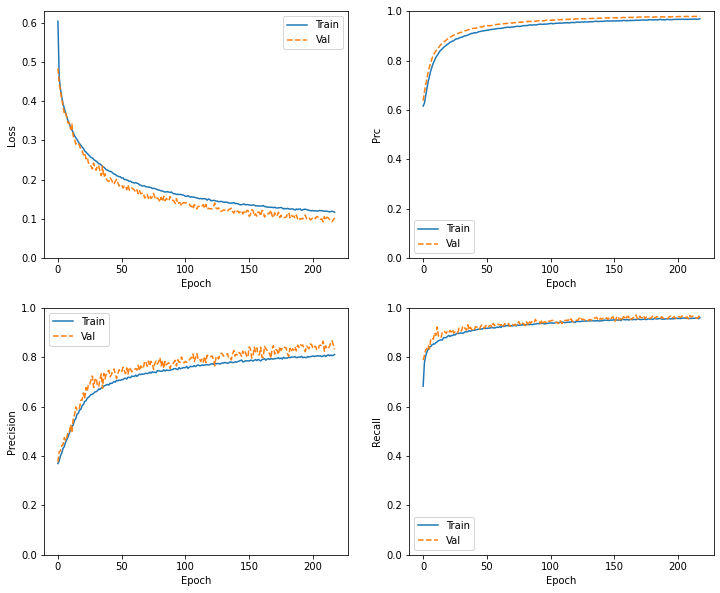

In [39]:
weighted_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

weighted_history = weighted_model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(weighted_history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                2560      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
44/44 [==============================] - 2s 14ms/step - loss: 0.6284 - accuracy: 0.8264 - precision: 0.5276 - recall: 0.5804 - auc: 0.8239 - prc: 0.6615 - val_loss: 0.3504 - val_accuracy: 0.8604 - val_precision: 0.9062 - val_recall: 0.2824 - val_auc: 0.8228 - val_prc: 0.6100
Epoch 2/500
44/44 [==============================] - 0s 5ms/step - loss: 0.3635 - accurac

Epoch 27/500
44/44 [==============================] - 0s 4ms/step - loss: 0.2037 - accuracy: 0.9210 - precision: 0.9030 - recall: 0.6478 - auc: 0.9507 - prc: 0.8694 - val_loss: 0.1921 - val_accuracy: 0.9272 - val_precision: 0.9283 - val_recall: 0.6616 - val_auc: 0.9585 - val_prc: 0.8896
Epoch 28/500
44/44 [==============================] - 0s 4ms/step - loss: 0.2025 - accuracy: 0.9218 - precision: 0.9033 - recall: 0.6527 - auc: 0.9511 - prc: 0.8722 - val_loss: 0.1897 - val_accuracy: 0.9280 - val_precision: 0.9241 - val_recall: 0.6699 - val_auc: 0.9602 - val_prc: 0.8931
Epoch 29/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1983 - accuracy: 0.9241 - precision: 0.9064 - recall: 0.6624 - auc: 0.9532 - prc: 0.8771 - val_loss: 0.1878 - val_accuracy: 0.9277 - val_precision: 0.9438 - val_recall: 0.6522 - val_auc: 0.9606 - val_prc: 0.8955
Epoch 30/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1942 - accuracy: 0.9251 - precision: 0.9146 - recall: 0.6617

44/44 [==============================] - 0s 5ms/step - loss: 0.1596 - accuracy: 0.9406 - precision: 0.9242 - recall: 0.7421 - auc: 0.9691 - prc: 0.9176 - val_loss: 0.1467 - val_accuracy: 0.9449 - val_precision: 0.9513 - val_recall: 0.7434 - val_auc: 0.9755 - val_prc: 0.9329
Epoch 56/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1576 - accuracy: 0.9416 - precision: 0.9242 - recall: 0.7467 - auc: 0.9695 - prc: 0.9189 - val_loss: 0.1453 - val_accuracy: 0.9464 - val_precision: 0.9373 - val_recall: 0.7643 - val_auc: 0.9760 - val_prc: 0.9340
Epoch 57/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1558 - accuracy: 0.9418 - precision: 0.9239 - recall: 0.7483 - auc: 0.9709 - prc: 0.9202 - val_loss: 0.1445 - val_accuracy: 0.9455 - val_precision: 0.9470 - val_recall: 0.7508 - val_auc: 0.9767 - val_prc: 0.9350
Epoch 58/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9431 - precision: 0.9295 - recall: 0.7500 - auc: 0.972

44/44 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9492 - precision: 0.9279 - recall: 0.7873 - auc: 0.9764 - prc: 0.9373 - val_loss: 0.1229 - val_accuracy: 0.9529 - val_precision: 0.9490 - val_recall: 0.7909 - val_auc: 0.9829 - val_prc: 0.9501
Epoch 84/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9491 - precision: 0.9272 - recall: 0.7877 - auc: 0.9774 - prc: 0.9373 - val_loss: 0.1222 - val_accuracy: 0.9532 - val_precision: 0.9542 - val_recall: 0.7877 - val_auc: 0.9833 - val_prc: 0.9515
Epoch 85/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1332 - accuracy: 0.9496 - precision: 0.9300 - recall: 0.7901 - auc: 0.9784 - prc: 0.9405 - val_loss: 0.1223 - val_accuracy: 0.9531 - val_precision: 0.9485 - val_recall: 0.7923 - val_auc: 0.9830 - val_prc: 0.9509
Epoch 86/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1315 - accuracy: 0.9503 - precision: 0.9318 - recall: 0.7888 - auc: 0.978

44/44 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9546 - precision: 0.9345 - recall: 0.8129 - auc: 0.9823 - prc: 0.9488 - val_loss: 0.1096 - val_accuracy: 0.9568 - val_precision: 0.9672 - val_recall: 0.7960 - val_auc: 0.9864 - val_prc: 0.9608
Epoch 112/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1200 - accuracy: 0.9534 - precision: 0.9310 - recall: 0.8103 - auc: 0.9826 - prc: 0.9501 - val_loss: 0.1082 - val_accuracy: 0.9584 - val_precision: 0.9569 - val_recall: 0.8140 - val_auc: 0.9866 - val_prc: 0.9610
Epoch 113/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9542 - precision: 0.9345 - recall: 0.8116 - auc: 0.9830 - prc: 0.9506 - val_loss: 0.1081 - val_accuracy: 0.9584 - val_precision: 0.9578 - val_recall: 0.8135 - val_auc: 0.9869 - val_prc: 0.9615
Epoch 114/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9523 - precision: 0.9292 - recall: 0.8095 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.1096 - accuracy: 0.9582 - precision: 0.9404 - recall: 0.8306 - auc: 0.9856 - prc: 0.9586 - val_loss: 0.0992 - val_accuracy: 0.9613 - val_precision: 0.9585 - val_recall: 0.8290 - val_auc: 0.9884 - val_prc: 0.9665
Epoch 140/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1109 - accuracy: 0.9575 - precision: 0.9339 - recall: 0.8328 - auc: 0.9853 - prc: 0.9572 - val_loss: 0.0986 - val_accuracy: 0.9630 - val_precision: 0.9488 - val_recall: 0.8476 - val_auc: 0.9886 - val_prc: 0.9668
Epoch 141/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9579 - precision: 0.9301 - recall: 0.8389 - auc: 0.9856 - prc: 0.9582 - val_loss: 0.0979 - val_accuracy: 0.9614 - val_precision: 0.9614 - val_recall: 0.8267 - val_auc: 0.9888 - val_prc: 0.9679
Epoch 142/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1090 - accuracy: 0.9573 - precision: 0.9363 - recall: 0.8254 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.1039 - accuracy: 0.9590 - precision: 0.9387 - recall: 0.8352 - auc: 0.9871 - prc: 0.9614 - val_loss: 0.0919 - val_accuracy: 0.9637 - val_precision: 0.9609 - val_recall: 0.8400 - val_auc: 0.9901 - val_prc: 0.9713
Epoch 168/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1030 - accuracy: 0.9595 - precision: 0.9359 - recall: 0.8414 - auc: 0.9875 - prc: 0.9620 - val_loss: 0.0924 - val_accuracy: 0.9634 - val_precision: 0.9593 - val_recall: 0.8400 - val_auc: 0.9898 - val_prc: 0.9704
Epoch 169/500
44/44 [==============================] - 0s 4ms/step - loss: 0.1013 - accuracy: 0.9608 - precision: 0.9378 - recall: 0.8456 - auc: 0.9875 - prc: 0.9624 - val_loss: 0.0914 - val_accuracy: 0.9643 - val_precision: 0.9626 - val_recall: 0.8417 - val_auc: 0.9901 - val_prc: 0.9715
Epoch 170/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 0.9619 - precision: 0.9361 - recall: 0.8534 - auc: 0.

44/44 [==============================] - 0s 5ms/step - loss: 0.0976 - accuracy: 0.9621 - precision: 0.9398 - recall: 0.8535 - auc: 0.9886 - prc: 0.9658 - val_loss: 0.0858 - val_accuracy: 0.9668 - val_precision: 0.9576 - val_recall: 0.8607 - val_auc: 0.9911 - val_prc: 0.9742
Epoch 196/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0947 - accuracy: 0.9629 - precision: 0.9336 - recall: 0.8620 - auc: 0.9891 - prc: 0.9669 - val_loss: 0.0862 - val_accuracy: 0.9661 - val_precision: 0.9651 - val_recall: 0.8496 - val_auc: 0.9912 - val_prc: 0.9743
Epoch 197/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0986 - accuracy: 0.9620 - precision: 0.9362 - recall: 0.8555 - auc: 0.9881 - prc: 0.9648 - val_loss: 0.0857 - val_accuracy: 0.9669 - val_precision: 0.9642 - val_recall: 0.8545 - val_auc: 0.9914 - val_prc: 0.9745
Epoch 198/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0958 - accuracy: 0.9629 - precision: 0.9399 - recall: 0.8552 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9659 - precision: 0.9431 - recall: 0.8690 - auc: 0.9900 - prc: 0.9698 - val_loss: 0.0814 - val_accuracy: 0.9686 - val_precision: 0.9573 - val_recall: 0.8707 - val_auc: 0.9919 - val_prc: 0.9764
Epoch 224/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0898 - accuracy: 0.9656 - precision: 0.9410 - recall: 0.8690 - auc: 0.9902 - prc: 0.9701 - val_loss: 0.0814 - val_accuracy: 0.9688 - val_precision: 0.9644 - val_recall: 0.8648 - val_auc: 0.9920 - val_prc: 0.9766
Epoch 225/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0908 - accuracy: 0.9646 - precision: 0.9407 - recall: 0.8674 - auc: 0.9903 - prc: 0.9700 - val_loss: 0.0807 - val_accuracy: 0.9694 - val_precision: 0.9517 - val_recall: 0.8813 - val_auc: 0.9921 - val_prc: 0.9767
Epoch 226/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9648 - precision: 0.9369 - recall: 0.8697 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0866 - accuracy: 0.9669 - precision: 0.9434 - recall: 0.8768 - auc: 0.9910 - prc: 0.9724 - val_loss: 0.0765 - val_accuracy: 0.9709 - val_precision: 0.9606 - val_recall: 0.8806 - val_auc: 0.9928 - val_prc: 0.9789
Epoch 252/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0863 - accuracy: 0.9680 - precision: 0.9441 - recall: 0.8805 - auc: 0.9907 - prc: 0.9723 - val_loss: 0.0770 - val_accuracy: 0.9712 - val_precision: 0.9666 - val_recall: 0.8761 - val_auc: 0.9927 - val_prc: 0.9790
Epoch 253/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0866 - accuracy: 0.9669 - precision: 0.9430 - recall: 0.8764 - auc: 0.9910 - prc: 0.9722 - val_loss: 0.0762 - val_accuracy: 0.9705 - val_precision: 0.9570 - val_recall: 0.8815 - val_auc: 0.9929 - val_prc: 0.9790
Epoch 254/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0864 - accuracy: 0.9677 - precision: 0.9413 - recall: 0.8831 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9677 - precision: 0.9445 - recall: 0.8800 - auc: 0.9914 - prc: 0.9742 - val_loss: 0.0732 - val_accuracy: 0.9727 - val_precision: 0.9637 - val_recall: 0.8874 - val_auc: 0.9933 - val_prc: 0.9806
Epoch 280/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9689 - precision: 0.9451 - recall: 0.8849 - auc: 0.9916 - prc: 0.9744 - val_loss: 0.0737 - val_accuracy: 0.9719 - val_precision: 0.9655 - val_recall: 0.8813 - val_auc: 0.9935 - val_prc: 0.9807
Epoch 281/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0826 - accuracy: 0.9695 - precision: 0.9448 - recall: 0.8878 - auc: 0.9916 - prc: 0.9740 - val_loss: 0.0725 - val_accuracy: 0.9728 - val_precision: 0.9555 - val_recall: 0.8963 - val_auc: 0.9938 - val_prc: 0.9807
Epoch 282/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0812 - accuracy: 0.9685 - precision: 0.9427 - recall: 0.8841 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9699 - precision: 0.9475 - recall: 0.8897 - auc: 0.9923 - prc: 0.9759 - val_loss: 0.0694 - val_accuracy: 0.9738 - val_precision: 0.9676 - val_recall: 0.8894 - val_auc: 0.9940 - val_prc: 0.9826
Epoch 308/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0802 - accuracy: 0.9699 - precision: 0.9437 - recall: 0.8928 - auc: 0.9922 - prc: 0.9757 - val_loss: 0.0703 - val_accuracy: 0.9735 - val_precision: 0.9617 - val_recall: 0.8938 - val_auc: 0.9937 - val_prc: 0.9819
Epoch 309/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0784 - accuracy: 0.9714 - precision: 0.9479 - recall: 0.8984 - auc: 0.9929 - prc: 0.9774 - val_loss: 0.0703 - val_accuracy: 0.9746 - val_precision: 0.9631 - val_recall: 0.8985 - val_auc: 0.9935 - val_prc: 0.9817
Epoch 310/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.9702 - precision: 0.9436 - recall: 0.8940 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9721 - precision: 0.9490 - recall: 0.8990 - auc: 0.9934 - prc: 0.9790 - val_loss: 0.0669 - val_accuracy: 0.9746 - val_precision: 0.9609 - val_recall: 0.9007 - val_auc: 0.9946 - val_prc: 0.9836
Epoch 336/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0764 - accuracy: 0.9721 - precision: 0.9482 - recall: 0.9004 - auc: 0.9931 - prc: 0.9780 - val_loss: 0.0667 - val_accuracy: 0.9756 - val_precision: 0.9715 - val_recall: 0.8960 - val_auc: 0.9948 - val_prc: 0.9839
Epoch 337/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.9720 - precision: 0.9501 - recall: 0.8985 - auc: 0.9931 - prc: 0.9789 - val_loss: 0.0690 - val_accuracy: 0.9735 - val_precision: 0.9750 - val_recall: 0.8811 - val_auc: 0.9942 - val_prc: 0.9834
Epoch 338/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.9719 - precision: 0.9510 - recall: 0.8969 - auc: 0.

44/44 [==============================] - 0s 4ms/step - loss: 0.0745 - accuracy: 0.9719 - precision: 0.9456 - recall: 0.9012 - auc: 0.9933 - prc: 0.9784 - val_loss: 0.0645 - val_accuracy: 0.9770 - val_precision: 0.9651 - val_recall: 0.9101 - val_auc: 0.9949 - val_prc: 0.9846
Epoch 364/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0753 - accuracy: 0.9722 - precision: 0.9476 - recall: 0.9009 - auc: 0.9934 - prc: 0.9782 - val_loss: 0.0647 - val_accuracy: 0.9763 - val_precision: 0.9729 - val_recall: 0.8985 - val_auc: 0.9951 - val_prc: 0.9851
Epoch 365/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0726 - accuracy: 0.9720 - precision: 0.9463 - recall: 0.9013 - auc: 0.9936 - prc: 0.9800 - val_loss: 0.0640 - val_accuracy: 0.9767 - val_precision: 0.9650 - val_recall: 0.9083 - val_auc: 0.9950 - val_prc: 0.9849
Epoch 366/500
44/44 [==============================] - 0s 4ms/step - loss: 0.0741 - accuracy: 0.9719 - precision: 0.9474 - recall: 0.8983 - auc: 0.

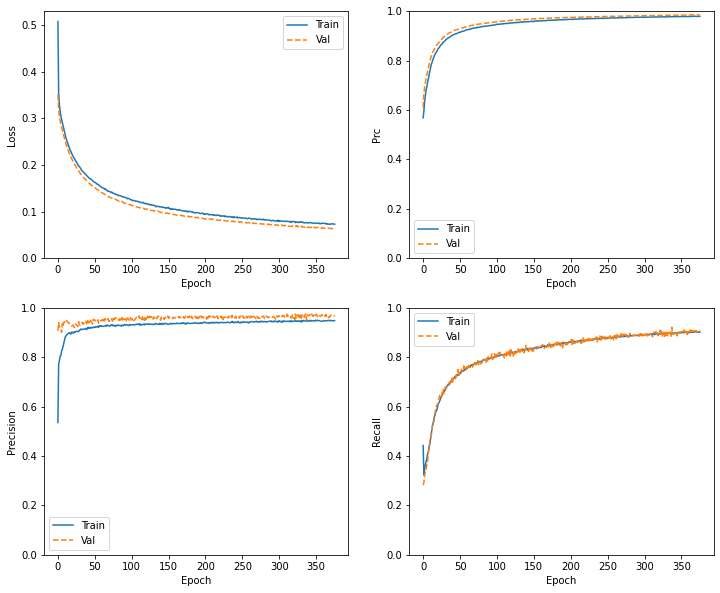

In [40]:
oversampled_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

oversampled_history = oversampled_model.fit(
            x=resampled_X_train, 
            y=resampled_y_train, 
            validation_data=(resampled_X_val, resampled_y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(oversampled_history)

And looking at the model performances for cutting stop frames.

--- BASELINE MODEL ---
loss :  0.058859046548604965
accuracy :  0.9777013063430786
precision :  0.9815974831581116
recall :  0.8963174819946289
auc :  0.9960331320762634
prc :  0.9875863194465637



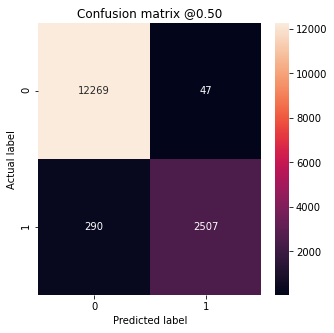


--- MODEL WITH CLASS WEIGHTS ---
loss :  0.10161012411117554
accuracy :  0.960828423500061
precision :  0.8485614657402039
recall :  0.9595995545387268
auc :  0.9940919280052185
prc :  0.9779192209243774



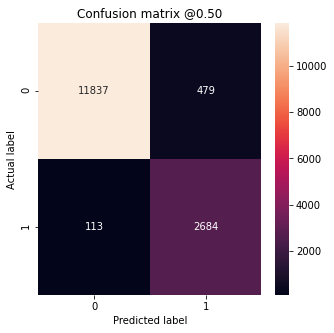


--- OVERSAMPLED MODEL ---
loss :  0.11153781414031982
accuracy :  0.9536916613578796
precision :  0.9923617243766785
recall :  0.9148522615432739
auc :  0.996402382850647
prc :  0.9966112375259399



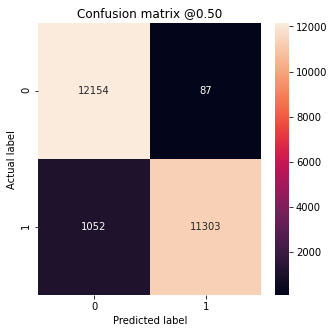

In [41]:
baseline_predictions = baseline_model.predict(X_test)
weighted_predictions = weighted_model.predict(X_test)
oversampled_predictions = oversampled_model.predict(resampled_X_test)

baseline_results = baseline_model.evaluate(X_test, 
                                          y_test,
                                          batch_size=BATCH_SIZE, 
                                          verbose=0)
weighted_results = weighted_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=BATCH_SIZE, 
                                              verbose=0)
oversampled_results = oversampled_model.evaluate(resampled_X_test, 
                                                resampled_y_test,
                                                batch_size=BATCH_SIZE, 
                                                verbose=0)

print('--- BASELINE MODEL ---')
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, baseline_predictions) 
print('')

print('--- MODEL WITH CLASS WEIGHTS ---')
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, weighted_predictions) 
print('')

print('--- OVERSAMPLED MODEL ---')
for name, value in zip(oversampled_model.metrics_names, oversampled_results):
  print(name, ': ', value)
print('')
plot_cm(resampled_y_test, oversampled_predictions) 

From looking at the metrics, confusion matrices, and ROC curves, we can draw the following conclusions:

- For cutting stop frames, usually the baseline model had the highest accuracy. The baseline and oversampled models again has an issue with FNs while the Weighted model has an issue with FPs. We think that the topic of precision and recall tradeoff and whether FP or FN are better in the context of this problem is debatable. On one hand, FN would mean that the model miss some start frames but at least it doesn't remove frames from the actual exercise. On the other than, if it would turn out that the models false positive predictions are spread out through the exercise, we could tell the model to only remove the predicted start frames from the beginning - and ignore the rest. And then hopefully not face any of the issues as a problem in the application.

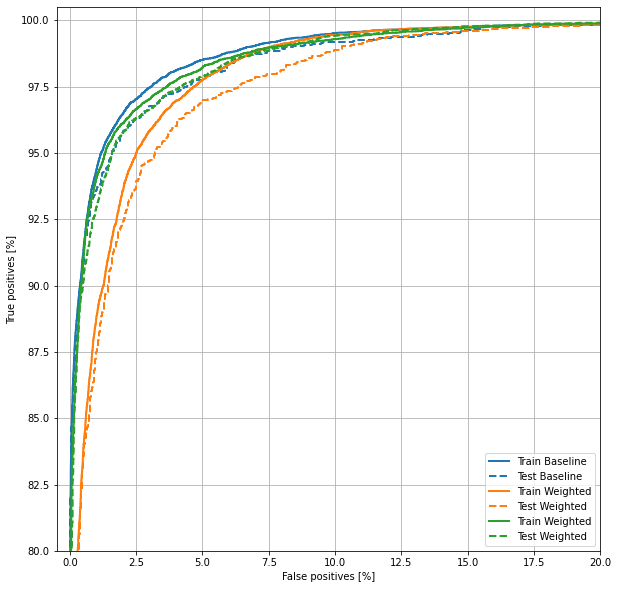

In [42]:
train_baseline_predictions = baseline_model.predict(X_train)
train_weighted_predictions = weighted_model.predict(X_train)
train_oversampled_predictions = oversampled_model.predict(resampled_X_train)

plot_roc("Train Baseline", y_train, train_baseline_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_weighted_predictions, color=colors[1])
plot_roc("Test Weighted", y_test, weighted_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", resampled_y_train, train_oversampled_predictions, color=colors[2])
plot_roc("Test Weighted", resampled_y_test, oversampled_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

## 2.2 Problem B (PoseNet)

In this section, we'll work with the PoseNet Start and Stop models.

### 2.2.1 PoseNet Cut Start model

We have worked in [cut_start_posenet.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment13/cut_start_posenet.ipynb) when experimenting with 7 versions of this model, and the experiment results are saved in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=[%22ca84e7c5b9e54551bd4708aa457bf730%22,%22ec7b7c39c9ea4803b374931c9cb2d92b%22,%22e9b518dc83024b1baf23c74fb7cc1bb3%22,%225cbe3aa3f27345f6aad4ba128ea27559%22,%22dc41930786ee44889f6eef1e6d48aa79%22,%223dab52757cf2466d8680c84a408abf44%22,%22736b3c7884be432bac642e0773e617dc%22]&experiment=0) for easy comparison.

Let's start by loading the dataset for PoseNet data.

In [43]:
data_path = 'https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/new_posenet_marked_start_end/'

df = None

In [44]:
# Loading A-files
for i in range(1, 160):
  try:
    dataset = pd.read_csv(data_path + 'A{}.csv'.format(i))
    dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='_score')))]
    dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='_eye_')))]
    dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='_ear_')))]
    dataset.rename(columns={'nose_x': 'head_x', 'nose_y': 'head_y'}, inplace=True)

    if df is None:
      df = dataset
    else:
      df = pd.concat((df, dataset), ignore_index=True)

  except IOError as e:
    print("Error in reading files: A{}.csv".format(i), e)

# Loading B-files
for i in range(1, 23):
  try:
    dataset = pd.read_csv(data_path + 'B{}.csv'.format(i))
    dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='_score')))]
    dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='_eye_')))]
    dataset = dataset[dataset.columns.drop(list(dataset.filter(regex='_ear_')))]
    dataset.rename(columns={'nose_x': 'head_x', 'nose_y': 'head_y'}, inplace=True)

    if df is None:
      df = dataset
    else:
      df = pd.concat((df, dataset), ignore_index=True)

  except IOError as e:
    print("Error in reading file: B{}.csv".format(i), e)

print(df.shape)

Error in reading files: A60.csv HTTP Error 404: Not Found
Error in reading files: A107.csv HTTP Error 404: Not Found
(141945, 28)


We need to create the X and y splits for PoseNet data as well, this time for PoseNet start frames.

In [45]:
X = df.drop(columns=['start', 'end'])
y = df['start']
y = y.astype(int)

X, y = shuffle(X, y)

In [46]:
from imblearn.over_sampling import SMOTE

random_state = 42
np.random.seed(random_state)

sm = SMOTE(random_state=random_state)
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

(225336, 26)
(225336,)


Training, validation, and test splits. Then normalizing.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [48]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=random_state)
resampled_X_train, resampled_X_val, resampled_y_train, resampled_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

resampled_scaler = StandardScaler()
resampled_X_train = resampled_scaler.fit_transform(resampled_X_train)

resampled_X_val = resampled_scaler.transform(resampled_X_val)
resampled_X_test = resampled_scaler.transform(resampled_X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (102200,)
Validation labels shape: (25550,)
Test labels shape: (14195,) 

Training features shape: (102200, 26)
Validation features shape: (25550, 26)
Test features shape: (14195, 26)


It's time for model training!

As we started working with Dense model variants to solve problem B with PoseNet dataset, we noticied that we could not use the same model architecture and parameter values on this model as with problem A because that resulted in a much worse performance.

So we updated the model architecture by adding two more fully-connected (Dense) layers to the model architecture. Which also noticeably increased the total amount of params for the model. For problem A, we could stick to a quite small model but for problem B, it required the model to be more advanced to reach a comparable performance.

In [50]:
def create_model(units, activation, kernel_initializer, output_activation, optimizer):
    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer))
    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer)) # Added this layer
    model.add(Dropout(0.2))
    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer)) # Added this layer
    if not output_activation:
      model.add(Dense(units=output_size))
    else:
      model.add(Dense(units=output_size, activation=output_activation))

    model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=METRICS)

    print(model.summary())

    return model

We also had to make the batch size noticeably smaller when training for this problem. Otherwise, we will use the same parameter values as for the models in the previous problem and we will use them for the baseline model, weighted model, and oversampled model for easy comparison.

In [51]:
BATCH_SIZE = 500

input_dim = X_train.shape[1]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 36,609
Trainable params: 36,609
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
205/205 [==============================] - 2s 5ms/step - loss: 0.4305 - accuracy: 0.8743 - precisio

Epoch 26/500
205/205 [==============================] - 1s 3ms/step - loss: 0.1158 - accuracy: 0.9505 - precision: 0.9110 - recall: 0.8450 - auc: 0.9864 - prc: 0.9585 - val_loss: 0.1070 - val_accuracy: 0.9532 - val_precision: 0.9272 - val_recall: 0.8379 - val_auc: 0.9888 - val_prc: 0.9640
Epoch 27/500
205/205 [==============================] - 1s 3ms/step - loss: 0.1161 - accuracy: 0.9510 - precision: 0.9160 - recall: 0.8410 - auc: 0.9863 - prc: 0.9587 - val_loss: 0.1113 - val_accuracy: 0.9532 - val_precision: 0.9305 - val_recall: 0.8343 - val_auc: 0.9875 - val_prc: 0.9615
Epoch 28/500
205/205 [==============================] - 1s 3ms/step - loss: 0.1126 - accuracy: 0.9532 - precision: 0.9129 - recall: 0.8557 - auc: 0.9871 - prc: 0.9607 - val_loss: 0.1008 - val_accuracy: 0.9582 - val_precision: 0.9379 - val_recall: 0.8526 - val_auc: 0.9901 - val_prc: 0.9678
Epoch 29/500
205/205 [==============================] - 1s 3ms/step - loss: 0.1087 - accuracy: 0.9544 - precision: 0.9178 - recall

205/205 [==============================] - 1s 3ms/step - loss: 0.0862 - accuracy: 0.9631 - precision: 0.9251 - recall: 0.8928 - auc: 0.9925 - prc: 0.9756 - val_loss: 0.0758 - val_accuracy: 0.9676 - val_precision: 0.9425 - val_recall: 0.8967 - val_auc: 0.9943 - val_prc: 0.9812
Epoch 55/500
205/205 [==============================] - 1s 3ms/step - loss: 0.0851 - accuracy: 0.9637 - precision: 0.9301 - recall: 0.8909 - auc: 0.9928 - prc: 0.9764 - val_loss: 0.0823 - val_accuracy: 0.9639 - val_precision: 0.9389 - val_recall: 0.8816 - val_auc: 0.9929 - val_prc: 0.9777
Epoch 56/500
205/205 [==============================] - 1s 3ms/step - loss: 0.0871 - accuracy: 0.9622 - precision: 0.9273 - recall: 0.8882 - auc: 0.9923 - prc: 0.9759 - val_loss: 0.0766 - val_accuracy: 0.9690 - val_precision: 0.9545 - val_recall: 0.8913 - val_auc: 0.9932 - val_prc: 0.9807
Epoch 57/500
205/205 [==============================] - 1s 3ms/step - loss: 0.0847 - accuracy: 0.9641 - precision: 0.9300 - recall: 0.8938 - au

205/205 [==============================] - 1s 3ms/step - loss: 0.0714 - accuracy: 0.9693 - precision: 0.9366 - recall: 0.9144 - auc: 0.9951 - prc: 0.9833 - val_loss: 0.0627 - val_accuracy: 0.9733 - val_precision: 0.9459 - val_recall: 0.9230 - val_auc: 0.9954 - val_prc: 0.9862
Epoch 83/500
205/205 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9701 - precision: 0.9350 - recall: 0.9197 - auc: 0.9950 - prc: 0.9835 - val_loss: 0.0655 - val_accuracy: 0.9719 - val_precision: 0.9350 - val_recall: 0.9277 - val_auc: 0.9954 - val_prc: 0.9852
Epoch 84/500
205/205 [==============================] - 1s 3ms/step - loss: 0.0673 - accuracy: 0.9714 - precision: 0.9370 - recall: 0.9236 - auc: 0.9955 - prc: 0.9848 - val_loss: 0.0642 - val_accuracy: 0.9728 - val_precision: 0.9505 - val_recall: 0.9150 - val_auc: 0.9956 - val_prc: 0.9856
Epoch 85/500
205/205 [==============================] - 1s 3ms/step - loss: 0.0704 - accuracy: 0.9704 - precision: 0.9380 - recall: 0.9186 - au

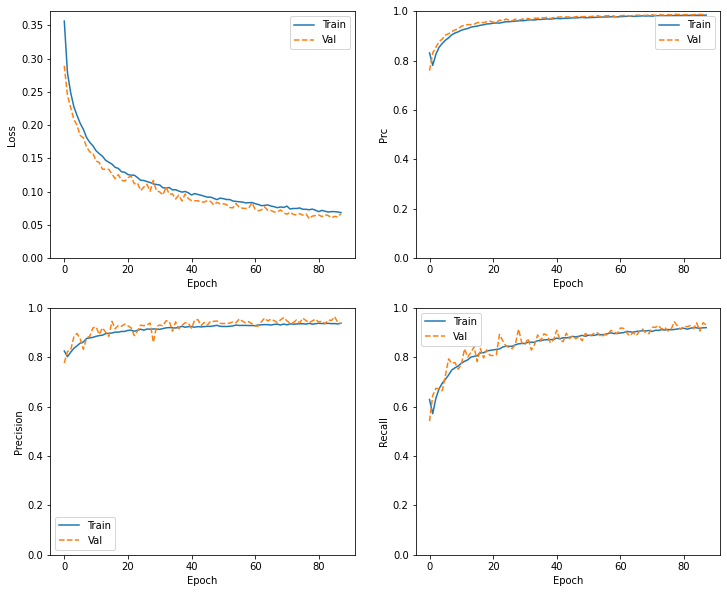

In [52]:
baseline_model = create_model(128, 'relu', 'he_uniform', 'sigmoid', 'adam')

baseline_history = baseline_model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(baseline_history)

And the weighted model.

In [53]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for start frames:', class_weights[1])
print('Weight for normal frames:', class_weights[0])

Weight for start frames: 2.417332891811344
Weight for normal frames: 0.6303894597895412


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
205/205 [==============================] - 2s 4ms/step - loss: 0.5192 - accuracy: 0.8306 - precisio

Epoch 26/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9155 - precision: 0.7348 - recall: 0.9235 - auc: 0.9777 - prc: 0.9301 - val_loss: 0.1777 - val_accuracy: 0.9226 - val_precision: 0.7521 - val_recall: 0.9295 - val_auc: 0.9829 - val_prc: 0.9438
Epoch 27/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9138 - precision: 0.7316 - recall: 0.9214 - auc: 0.9778 - prc: 0.9299 - val_loss: 0.1604 - val_accuracy: 0.9331 - val_precision: 0.7866 - val_recall: 0.9251 - val_auc: 0.9839 - val_prc: 0.9467
Epoch 28/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9153 - precision: 0.7362 - recall: 0.9253 - auc: 0.9778 - prc: 0.9307 - val_loss: 0.1714 - val_accuracy: 0.9254 - val_precision: 0.7559 - val_recall: 0.9405 - val_auc: 0.9834 - val_prc: 0.9463
Epoch 29/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1815 - accuracy: 0.9189 - precision: 0.7423 - recall

205/205 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9348 - precision: 0.7822 - recall: 0.9497 - auc: 0.9871 - prc: 0.9570 - val_loss: 0.1297 - val_accuracy: 0.9443 - val_precision: 0.8096 - val_recall: 0.9527 - val_auc: 0.9898 - val_prc: 0.9651
Epoch 55/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1424 - accuracy: 0.9356 - precision: 0.7852 - recall: 0.9502 - auc: 0.9874 - prc: 0.9563 - val_loss: 0.1211 - val_accuracy: 0.9505 - val_precision: 0.8331 - val_recall: 0.9491 - val_auc: 0.9906 - val_prc: 0.9681
Epoch 56/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9379 - precision: 0.7900 - recall: 0.9517 - auc: 0.9884 - prc: 0.9602 - val_loss: 0.1114 - val_accuracy: 0.9547 - val_precision: 0.8507 - val_recall: 0.9453 - val_auc: 0.9913 - val_prc: 0.9693
Epoch 57/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.9380 - precision: 0.7883 - recall: 0.9522 - au

205/205 [==============================] - 0s 2ms/step - loss: 0.1201 - accuracy: 0.9459 - precision: 0.8122 - recall: 0.9603 - auc: 0.9909 - prc: 0.9678 - val_loss: 0.1105 - val_accuracy: 0.9539 - val_precision: 0.8361 - val_recall: 0.9642 - val_auc: 0.9924 - val_prc: 0.9713
Epoch 83/500
205/205 [==============================] - 1s 3ms/step - loss: 0.1229 - accuracy: 0.9451 - precision: 0.8096 - recall: 0.9601 - auc: 0.9902 - prc: 0.9644 - val_loss: 0.1048 - val_accuracy: 0.9551 - val_precision: 0.8400 - val_recall: 0.9649 - val_auc: 0.9930 - val_prc: 0.9755
Epoch 84/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1213 - accuracy: 0.9453 - precision: 0.8093 - recall: 0.9584 - auc: 0.9906 - prc: 0.9665 - val_loss: 0.1219 - val_accuracy: 0.9491 - val_precision: 0.8191 - val_recall: 0.9653 - val_auc: 0.9918 - val_prc: 0.9713
Epoch 85/500
205/205 [==============================] - 1s 2ms/step - loss: 0.1243 - accuracy: 0.9436 - precision: 0.8065 - recall: 0.9550 - au

205/205 [==============================] - 0s 2ms/step - loss: 0.1120 - accuracy: 0.9491 - precision: 0.8219 - recall: 0.9626 - auc: 0.9920 - prc: 0.9717 - val_loss: 0.1031 - val_accuracy: 0.9561 - val_precision: 0.8367 - val_recall: 0.9767 - val_auc: 0.9942 - val_prc: 0.9806
Epoch 111/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.9494 - precision: 0.8222 - recall: 0.9668 - auc: 0.9924 - prc: 0.9732 - val_loss: 0.1027 - val_accuracy: 0.9563 - val_precision: 0.8404 - val_recall: 0.9716 - val_auc: 0.9934 - val_prc: 0.9780
Epoch 112/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.9489 - precision: 0.8202 - recall: 0.9642 - auc: 0.9919 - prc: 0.9703 - val_loss: 0.0906 - val_accuracy: 0.9598 - val_precision: 0.8642 - val_recall: 0.9541 - val_auc: 0.9934 - val_prc: 0.9775
Epoch 113/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1133 - accuracy: 0.9470 - precision: 0.8138 - recall: 0.9636 -

205/205 [==============================] - 0s 2ms/step - loss: 0.1031 - accuracy: 0.9538 - precision: 0.8350 - recall: 0.9675 - auc: 0.9931 - prc: 0.9745 - val_loss: 0.0890 - val_accuracy: 0.9640 - val_precision: 0.8661 - val_recall: 0.9752 - val_auc: 0.9947 - val_prc: 0.9817
Epoch 139/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9531 - precision: 0.8335 - recall: 0.9662 - auc: 0.9929 - prc: 0.9734 - val_loss: 0.0807 - val_accuracy: 0.9677 - val_precision: 0.8808 - val_recall: 0.9745 - val_auc: 0.9953 - val_prc: 0.9840
Epoch 140/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1027 - accuracy: 0.9531 - precision: 0.8307 - recall: 0.9677 - auc: 0.9930 - prc: 0.9736 - val_loss: 0.0819 - val_accuracy: 0.9688 - val_precision: 0.8866 - val_recall: 0.9722 - val_auc: 0.9949 - val_prc: 0.9820
Epoch 141/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1025 - accuracy: 0.9543 - precision: 0.8361 - recall: 0.9667 -

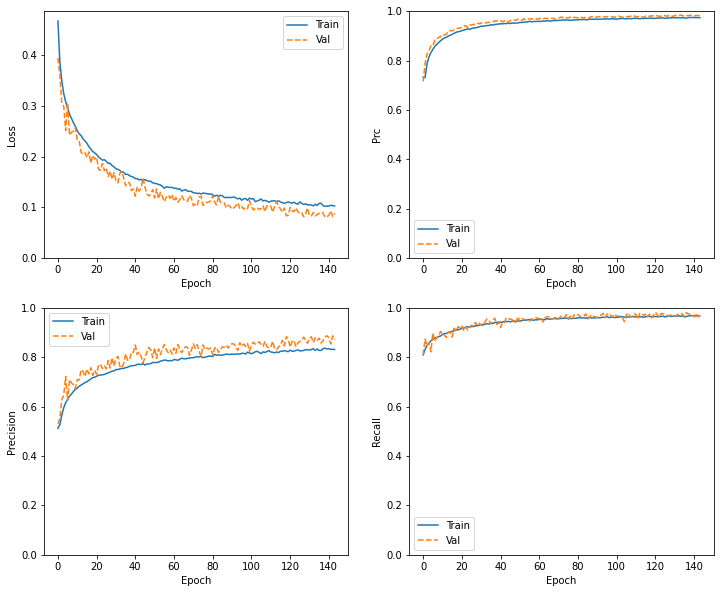

In [54]:
weighted_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

weighted_history = weighted_model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(weighted_history)

And the oversampled model.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
164/164 [==============================] - 2s 5ms/step - loss: 0.4540 - accuracy: 0.8773 - precisio

Epoch 26/500
164/164 [==============================] - 0s 3ms/step - loss: 0.1608 - accuracy: 0.9357 - precision: 0.8916 - recall: 0.7855 - auc: 0.9727 - prc: 0.9250 - val_loss: 0.1379 - val_accuracy: 0.9459 - val_precision: 0.9104 - val_recall: 0.8161 - val_auc: 0.9807 - val_prc: 0.9448
Epoch 27/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1575 - accuracy: 0.9341 - precision: 0.8850 - recall: 0.7825 - auc: 0.9741 - prc: 0.9266 - val_loss: 0.1351 - val_accuracy: 0.9475 - val_precision: 0.9057 - val_recall: 0.8301 - val_auc: 0.9817 - val_prc: 0.9473
Epoch 28/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1565 - accuracy: 0.9358 - precision: 0.8936 - recall: 0.7873 - auc: 0.9745 - prc: 0.9299 - val_loss: 0.1339 - val_accuracy: 0.9477 - val_precision: 0.8934 - val_recall: 0.8452 - val_auc: 0.9822 - val_prc: 0.9491
Epoch 29/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1541 - accuracy: 0.9357 - precision: 0.8895 - recall

164/164 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9459 - precision: 0.9006 - recall: 0.8283 - auc: 0.9833 - prc: 0.9496 - val_loss: 0.1095 - val_accuracy: 0.9555 - val_precision: 0.9118 - val_recall: 0.8665 - val_auc: 0.9884 - val_prc: 0.9632
Epoch 55/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1287 - accuracy: 0.9461 - precision: 0.8997 - recall: 0.8309 - auc: 0.9829 - prc: 0.9486 - val_loss: 0.1050 - val_accuracy: 0.9575 - val_precision: 0.9280 - val_recall: 0.8593 - val_auc: 0.9889 - val_prc: 0.9663
Epoch 56/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1263 - accuracy: 0.9470 - precision: 0.9041 - recall: 0.8333 - auc: 0.9839 - prc: 0.9517 - val_loss: 0.1041 - val_accuracy: 0.9606 - val_precision: 0.9270 - val_recall: 0.8765 - val_auc: 0.9896 - val_prc: 0.9681
Epoch 57/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1233 - accuracy: 0.9492 - precision: 0.9099 - recall: 0.8369 - au

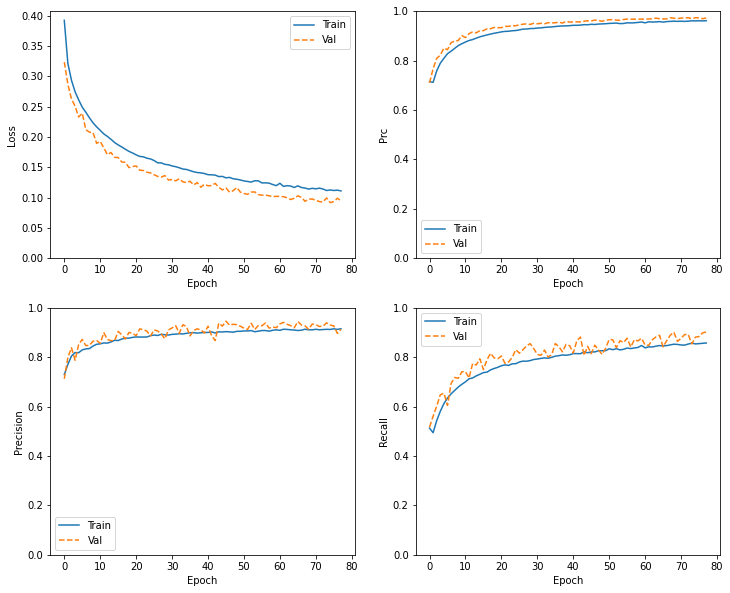

In [55]:
oversampled_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

oversampled_history = oversampled_model.fit(
            x=resampled_X_train, 
            y=resampled_y_train, 
            validation_data=(resampled_X_val, resampled_y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(oversampled_history)

When comparing model performances for cutting PoseNet start frames, we found that:

- It was not at all as easy to train the model on cutting start frames for PoseNet data as it was for Kinect data;
- Even though we added two Dense layers and decreased the batch size, the predictive performance for this model could not entirely reach the Kinect models. However, the baseline model here achieved more or less the same performance as the Kinect baseline model; and
- Just as with the Kinect models, these PoseNet Cut Start models are weak at either precision or recall - depending on what type of imbalanced dataset technique that was used.

--- BASELINE MODEL ---
loss :  0.06125444918870926
accuracy :  0.9759774804115295
precision :  0.9406077265739441
recall :  0.9415831565856934
auc :  0.996322512626648
prc :  0.9878162145614624



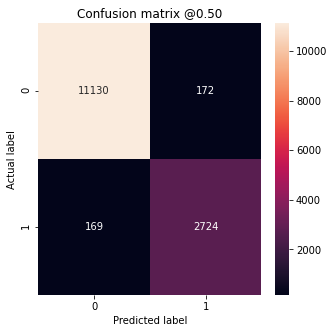


--- MODEL WITH CLASS WEIGHTS ---
loss :  0.08769290149211884
accuracy :  0.9652694463729858
precision :  0.870141863822937
recall :  0.9751123189926147
auc :  0.9952595829963684
prc :  0.9831331968307495



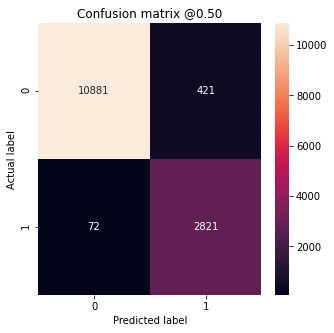


--- OVERSAMPLED MODEL ---
loss :  0.14447768032550812
accuracy :  0.9361409544944763
precision :  0.9807217121124268
recall :  0.8885704278945923
auc :  0.9919546246528625
prc :  0.9921016097068787



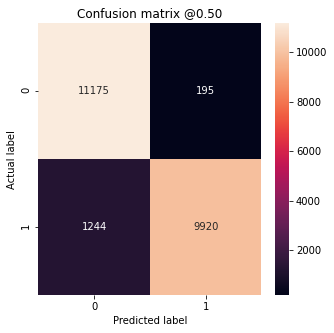

In [56]:
baseline_predictions = baseline_model.predict(X_test)
weighted_predictions = weighted_model.predict(X_test)
oversampled_predictions = oversampled_model.predict(resampled_X_test)

baseline_results = baseline_model.evaluate(X_test, 
                                          y_test,
                                          batch_size=BATCH_SIZE, 
                                          verbose=0)
weighted_results = weighted_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=BATCH_SIZE, 
                                              verbose=0)
oversampled_results = oversampled_model.evaluate(resampled_X_test, 
                                                resampled_y_test,
                                                batch_size=BATCH_SIZE, 
                                                verbose=0)

print('--- BASELINE MODEL ---')
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, baseline_predictions) 
print('')

print('--- MODEL WITH CLASS WEIGHTS ---')
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, weighted_predictions) 
print('')

print('--- OVERSAMPLED MODEL ---')
for name, value in zip(oversampled_model.metrics_names, oversampled_results):
  print(name, ': ', value)
print('')
plot_cm(resampled_y_test, oversampled_predictions) 

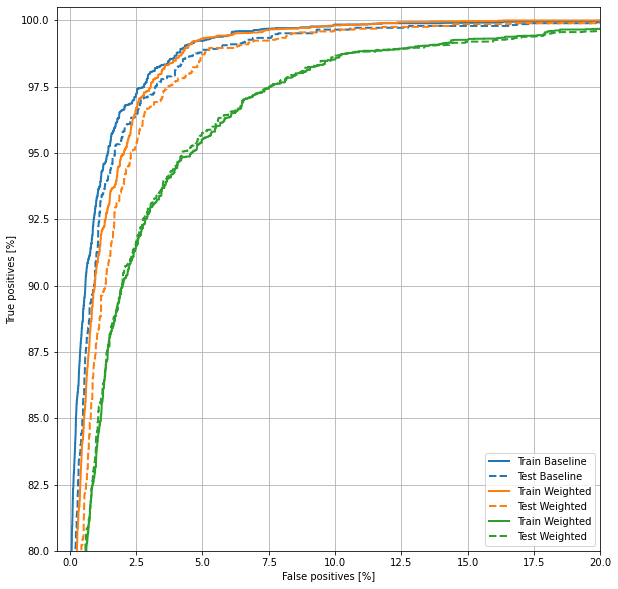

In [57]:
train_baseline_predictions = baseline_model.predict(X_train)
train_weighted_predictions = weighted_model.predict(X_train)
train_oversampled_predictions = oversampled_model.predict(resampled_X_train)

plot_roc("Train Baseline", y_train, train_baseline_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_weighted_predictions, color=colors[1])
plot_roc("Test Weighted", y_test, weighted_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", resampled_y_train, train_oversampled_predictions, color=colors[2])
plot_roc("Test Weighted", resampled_y_test, oversampled_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

### 2.2.2 PoseNet Cut Stop model

We have worked in [cut_stop_posenet.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment13/cut_stop_posenet.ipynb) when experimenting with this model, and the experiment results are saved in [MLflow dashboard](http://35.228.45.76:5000/#/experiments/0/runs/583700c9367d4a49ad54912df95cf3cb). We did not have to experiment as much with this model as it worked very similar to cutting start frames from the same Posenet data.

We do not have to load the dataset again, but we do need to recreate the X and y sets because before, we dropped the "end" column and kept the "start" column, but now we have to do the reversed situation.

In [58]:
X = df.drop(columns=['end', 'start'])
y = df['end']
y = y.astype(int)

X, y = shuffle(X, y)

In [59]:
random_state = 42
np.random.seed(random_state)

sm = SMOTE(random_state=random_state)
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

(237442, 26)
(237442,)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [61]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=random_state)
resampled_X_train, resampled_X_val, resampled_y_train, resampled_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

resampled_scaler = StandardScaler()
resampled_X_train = resampled_scaler.fit_transform(resampled_X_train)

resampled_X_val = resampled_scaler.transform(resampled_X_val)
resampled_X_test = resampled_scaler.transform(resampled_X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (102200,)
Validation labels shape: (25550,)
Test labels shape: (14195,) 

Training features shape: (102200, 26)
Validation features shape: (25550, 26)
Test features shape: (14195, 26)


And then we begin the experimentation with the baseline model, followed by the weighted model, and lastly the oversampled model - all for cutting PoseNet stop frames.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
205/205 [==============================] - 2s 5ms/step - loss: 0.4474 - accuracy: 0.8710 - precisio

Epoch 26/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1118 - accuracy: 0.9526 - precision: 0.8717 - recall: 0.8302 - auc: 0.9846 - prc: 0.9371 - val_loss: 0.1071 - val_accuracy: 0.9532 - val_precision: 0.8740 - val_recall: 0.8401 - val_auc: 0.9861 - val_prc: 0.9437
Epoch 27/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9527 - precision: 0.8692 - recall: 0.8331 - auc: 0.9851 - prc: 0.9377 - val_loss: 0.1067 - val_accuracy: 0.9537 - val_precision: 0.8658 - val_recall: 0.8544 - val_auc: 0.9860 - val_prc: 0.9438
Epoch 28/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1126 - accuracy: 0.9512 - precision: 0.8652 - recall: 0.8327 - auc: 0.9847 - prc: 0.9372 - val_loss: 0.1045 - val_accuracy: 0.9554 - val_precision: 0.8848 - val_recall: 0.8415 - val_auc: 0.9871 - val_prc: 0.9472
Epoch 29/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1101 - accuracy: 0.9534 - precision: 0.8712 - recall

205/205 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9616 - precision: 0.8915 - recall: 0.8733 - auc: 0.9902 - prc: 0.9592 - val_loss: 0.0842 - val_accuracy: 0.9637 - val_precision: 0.8927 - val_recall: 0.8888 - val_auc: 0.9908 - val_prc: 0.9648
Epoch 55/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9625 - precision: 0.8939 - recall: 0.8737 - auc: 0.9910 - prc: 0.9618 - val_loss: 0.0839 - val_accuracy: 0.9657 - val_precision: 0.9209 - val_recall: 0.8683 - val_auc: 0.9907 - val_prc: 0.9645
Epoch 56/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9634 - precision: 0.8988 - recall: 0.8755 - auc: 0.9908 - prc: 0.9621 - val_loss: 0.0855 - val_accuracy: 0.9636 - val_precision: 0.9121 - val_recall: 0.8643 - val_auc: 0.9907 - val_prc: 0.9639
Epoch 57/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0871 - accuracy: 0.9622 - precision: 0.8926 - recall: 0.8754 - au

205/205 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9674 - precision: 0.9057 - recall: 0.8936 - auc: 0.9927 - prc: 0.9696 - val_loss: 0.0743 - val_accuracy: 0.9687 - val_precision: 0.9187 - val_recall: 0.8909 - val_auc: 0.9929 - val_prc: 0.9719
Epoch 83/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0768 - accuracy: 0.9668 - precision: 0.9012 - recall: 0.8898 - auc: 0.9924 - prc: 0.9684 - val_loss: 0.0778 - val_accuracy: 0.9685 - val_precision: 0.9085 - val_recall: 0.9012 - val_auc: 0.9925 - val_prc: 0.9700
Epoch 84/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9677 - precision: 0.9083 - recall: 0.8915 - auc: 0.9927 - prc: 0.9695 - val_loss: 0.0755 - val_accuracy: 0.9688 - val_precision: 0.9233 - val_recall: 0.8862 - val_auc: 0.9928 - val_prc: 0.9721
Epoch 85/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0789 - accuracy: 0.9674 - precision: 0.9102 - recall: 0.8902 - au

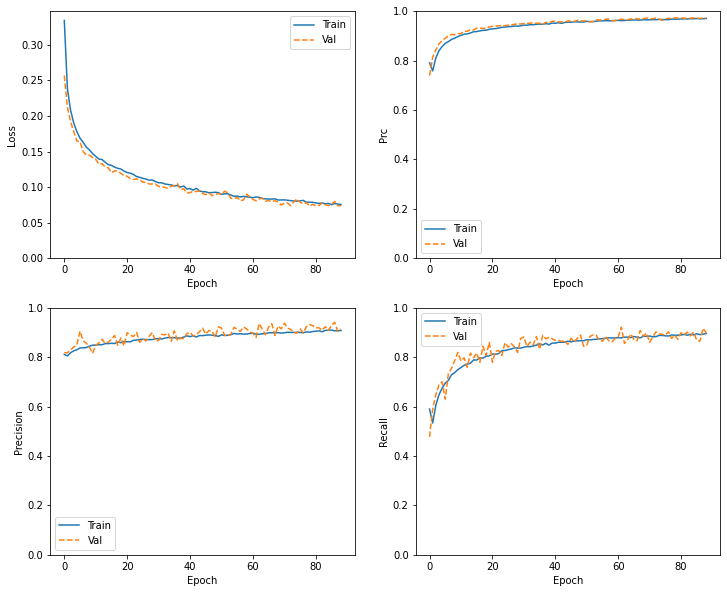

In [63]:
baseline_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

baseline_history = baseline_model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(baseline_history)

In [64]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for normal frames:', class_weights[0])
print('Weight for stop frames:', class_weights[1])

Weight for normal frames: 0.5975210477081384
Weight for stop frames: 3.063549160671463


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
205/205 [==============================] - 2s 5ms/step - loss: 0.4667 - accuracy: 0.8629 - precisi

Epoch 26/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9324 - precision: 0.7199 - recall: 0.9660 - auc: 0.9868 - prc: 0.9365 - val_loss: 0.1493 - val_accuracy: 0.9317 - val_precision: 0.7177 - val_recall: 0.9718 - val_auc: 0.9873 - val_prc: 0.9404
Epoch 27/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1384 - accuracy: 0.9321 - precision: 0.7146 - recall: 0.9673 - auc: 0.9869 - prc: 0.9367 - val_loss: 0.1459 - val_accuracy: 0.9359 - val_precision: 0.7316 - val_recall: 0.9713 - val_auc: 0.9882 - val_prc: 0.9414
Epoch 28/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.9300 - precision: 0.7093 - recall: 0.9608 - auc: 0.9861 - prc: 0.9328 - val_loss: 0.1312 - val_accuracy: 0.9413 - val_precision: 0.7529 - val_recall: 0.9638 - val_auc: 0.9892 - val_prc: 0.9494
Epoch 29/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1364 - accuracy: 0.9336 - precision: 0.7232 - recall

205/205 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.9461 - precision: 0.7608 - recall: 0.9721 - auc: 0.9912 - prc: 0.9549 - val_loss: 0.1115 - val_accuracy: 0.9520 - val_precision: 0.7923 - val_recall: 0.9645 - val_auc: 0.9912 - val_prc: 0.9574
Epoch 55/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1123 - accuracy: 0.9460 - precision: 0.7586 - recall: 0.9741 - auc: 0.9912 - prc: 0.9567 - val_loss: 0.1113 - val_accuracy: 0.9495 - val_precision: 0.7801 - val_recall: 0.9697 - val_auc: 0.9914 - val_prc: 0.9598
Epoch 56/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1079 - accuracy: 0.9472 - precision: 0.7677 - recall: 0.9763 - auc: 0.9917 - prc: 0.9594 - val_loss: 0.1083 - val_accuracy: 0.9510 - val_precision: 0.7872 - val_recall: 0.9668 - val_auc: 0.9922 - val_prc: 0.9631
Epoch 57/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1125 - accuracy: 0.9457 - precision: 0.7611 - recall: 0.9743 - au

205/205 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.9497 - precision: 0.7744 - recall: 0.9770 - auc: 0.9928 - prc: 0.9641 - val_loss: 0.1016 - val_accuracy: 0.9548 - val_precision: 0.7963 - val_recall: 0.9784 - val_auc: 0.9937 - val_prc: 0.9699
Epoch 83/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9482 - precision: 0.7659 - recall: 0.9802 - auc: 0.9924 - prc: 0.9628 - val_loss: 0.1080 - val_accuracy: 0.9533 - val_precision: 0.7953 - val_recall: 0.9687 - val_auc: 0.9920 - val_prc: 0.9632
Epoch 84/500
205/205 [==============================] - 0s 2ms/step - loss: 0.0999 - accuracy: 0.9506 - precision: 0.7798 - recall: 0.9784 - auc: 0.9929 - prc: 0.9650 - val_loss: 0.0967 - val_accuracy: 0.9581 - val_precision: 0.8111 - val_recall: 0.9755 - val_auc: 0.9936 - val_prc: 0.9695
Epoch 85/500
205/205 [==============================] - 0s 2ms/step - loss: 0.1008 - accuracy: 0.9504 - precision: 0.7774 - recall: 0.9769 - au

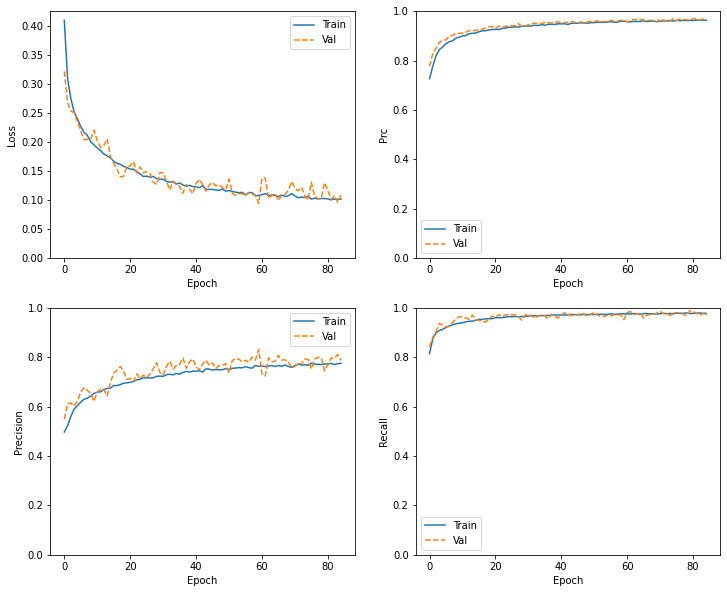

In [65]:
weighted_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

weighted_history = weighted_model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(weighted_history)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
164/164 [==============================] - 2s 5ms/step - loss: 0.4282 - accuracy: 0.8903 - precisi

Epoch 26/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1233 - accuracy: 0.9486 - precision: 0.8659 - recall: 0.8128 - auc: 0.9819 - prc: 0.9261 - val_loss: 0.1110 - val_accuracy: 0.9539 - val_precision: 0.8862 - val_recall: 0.8243 - val_auc: 0.9856 - val_prc: 0.9417
Epoch 27/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1200 - accuracy: 0.9507 - precision: 0.8741 - recall: 0.8165 - auc: 0.9827 - prc: 0.9304 - val_loss: 0.1078 - val_accuracy: 0.9558 - val_precision: 0.8991 - val_recall: 0.8225 - val_auc: 0.9861 - val_prc: 0.9442
Epoch 28/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1152 - accuracy: 0.9513 - precision: 0.8761 - recall: 0.8177 - auc: 0.9841 - prc: 0.9346 - val_loss: 0.1071 - val_accuracy: 0.9541 - val_precision: 0.8981 - val_recall: 0.8117 - val_auc: 0.9862 - val_prc: 0.9444
Epoch 29/500
164/164 [==============================] - 0s 2ms/step - loss: 0.1176 - accuracy: 0.9505 - precision: 0.8739 - recall

164/164 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9604 - precision: 0.8943 - recall: 0.8626 - auc: 0.9894 - prc: 0.9563 - val_loss: 0.0839 - val_accuracy: 0.9656 - val_precision: 0.9052 - val_recall: 0.8819 - val_auc: 0.9911 - val_prc: 0.9653
Epoch 55/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0930 - accuracy: 0.9597 - precision: 0.8947 - recall: 0.8540 - auc: 0.9893 - prc: 0.9564 - val_loss: 0.0860 - val_accuracy: 0.9635 - val_precision: 0.9257 - val_recall: 0.8449 - val_auc: 0.9911 - val_prc: 0.9638
Epoch 56/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0894 - accuracy: 0.9625 - precision: 0.8990 - recall: 0.8647 - auc: 0.9903 - prc: 0.9582 - val_loss: 0.0841 - val_accuracy: 0.9656 - val_precision: 0.9077 - val_recall: 0.8790 - val_auc: 0.9916 - val_prc: 0.9649
Epoch 57/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0921 - accuracy: 0.9616 - precision: 0.8957 - recall: 0.8662 - au

164/164 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9668 - precision: 0.9133 - recall: 0.8817 - auc: 0.9921 - prc: 0.9681 - val_loss: 0.0762 - val_accuracy: 0.9665 - val_precision: 0.9266 - val_recall: 0.8640 - val_auc: 0.9928 - val_prc: 0.9709
Epoch 83/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9663 - precision: 0.9099 - recall: 0.8809 - auc: 0.9925 - prc: 0.9676 - val_loss: 0.0826 - val_accuracy: 0.9677 - val_precision: 0.9338 - val_recall: 0.8637 - val_auc: 0.9909 - val_prc: 0.9663
Epoch 84/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.9657 - precision: 0.9095 - recall: 0.8771 - auc: 0.9921 - prc: 0.9664 - val_loss: 0.0753 - val_accuracy: 0.9690 - val_precision: 0.9335 - val_recall: 0.8727 - val_auc: 0.9930 - val_prc: 0.9715
Epoch 85/500
164/164 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9683 - precision: 0.9174 - recall: 0.8847 - au

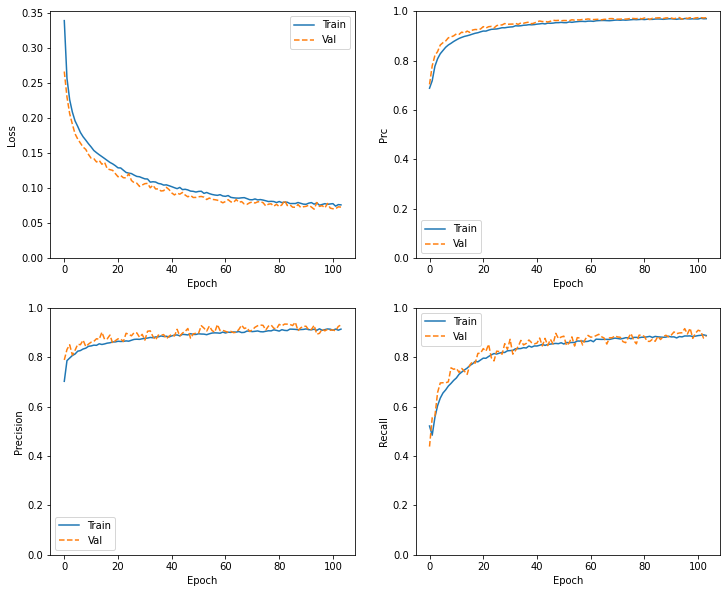

In [66]:
oversampled_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

oversampled_history = oversampled_model.fit(
            x=resampled_X_train, 
            y=resampled_y_train, 
            validation_data=(resampled_X_val, resampled_y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(oversampled_history)

These three model variants had a closer performance so it is difficult to find larger differences between them, but just as with the other experimentations, baseline achieves the highest accuracy. 

--- BASELINE MODEL ---
loss :  0.07212422043085098
accuracy :  0.9708347916603088
precision :  0.9295517206192017
recall :  0.886561930179596
auc :  0.9935880899429321
prc :  0.9718015193939209



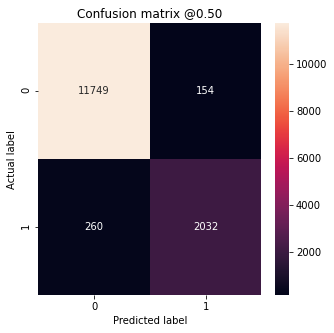


--- MODEL WITH CLASS WEIGHTS ---
loss :  0.10105625540018082
accuracy :  0.9530116319656372
precision :  0.7831997275352478
recall :  0.9803664684295654
auc :  0.994020938873291
prc :  0.9697340726852417



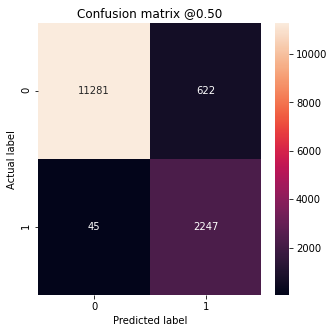


--- OVERSAMPLED MODEL ---
loss :  0.1279103308916092
accuracy :  0.94461989402771
precision :  0.9866994619369507
recall :  0.9025833606719971
auc :  0.9948740601539612
prc :  0.9949455857276917



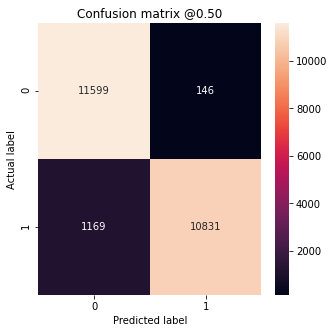

In [67]:
baseline_predictions = baseline_model.predict(X_test)
weighted_predictions = weighted_model.predict(X_test)
oversampled_predictions = oversampled_model.predict(resampled_X_test)

baseline_results = baseline_model.evaluate(X_test, 
                                          y_test,
                                          batch_size=BATCH_SIZE, 
                                          verbose=0)
weighted_results = weighted_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=BATCH_SIZE, 
                                              verbose=0)
oversampled_results = oversampled_model.evaluate(resampled_X_test, 
                                                resampled_y_test,
                                                batch_size=BATCH_SIZE, 
                                                verbose=0)

print('--- BASELINE MODEL ---')
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, baseline_predictions) 
print('')

print('--- MODEL WITH CLASS WEIGHTS ---')
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, weighted_predictions) 
print('')

print('--- OVERSAMPLED MODEL ---')
for name, value in zip(oversampled_model.metrics_names, oversampled_results):
  print(name, ': ', value)
print('')
plot_cm(resampled_y_test, oversampled_predictions) 

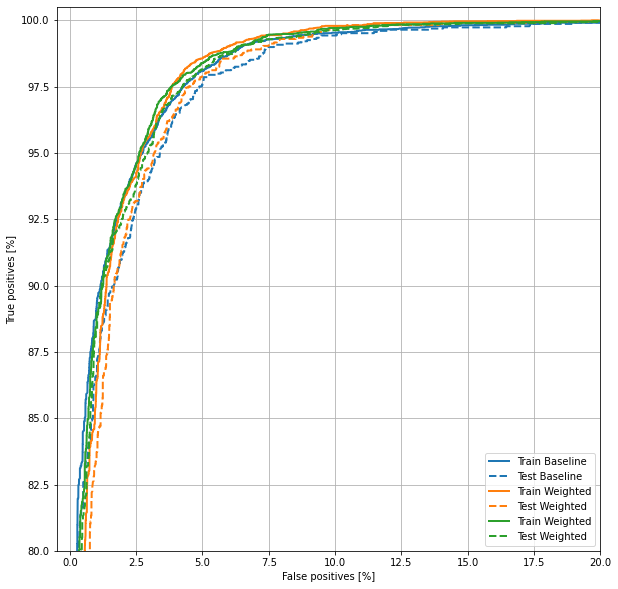

In [68]:
train_baseline_predictions = baseline_model.predict(X_train)
train_weighted_predictions = weighted_model.predict(X_train)
train_oversampled_predictions = oversampled_model.predict(resampled_X_train)

plot_roc("Train Baseline", y_train, train_baseline_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_weighted_predictions, color=colors[1])
plot_roc("Test Weighted", y_test, weighted_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", resampled_y_train, train_oversampled_predictions, color=colors[2])
plot_roc("Test Weighted", resampled_y_test, oversampled_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

# 3. Conclusions and The Champion Model

Generally, it seemed like the baseline model that did not use oversampling or class weights could achieve the highest accuracy and best performances. 
Perhaps this was because the dataset was not super imbalanced (almost 20% vs 80% for start/stop frames vs normal frames) and we also used data augmentation on top of that. But we don't know, that is simply a guess.<br />
When comparing the two imbalanced dataset techniques, it was always oversampling that gave the best performance.

At the end of this experimentation, we needed to decide if we were going to implement the cut start and cut stop models into our application pipeline for either PoseNet or Kinect, so we had to compare the model performances and make a decision. 

The baseline models for both problems have very similar performance, so we could use either Kinect models or PoseNet models to cut the start and stop frames in our application pipeline. <br />
We believe PoseNet models would be the best choice in this case because one of the other models in our pipeline (Kinect 2D -> 3D model) does not have the best performance and therefore we want to avoid that model to in any way affect the performance of these models via the interaction in the pipeline.

# 4. Jira Updates (this part is kept intact from the first submission)

In this section, we're presenting the updates we've made to our workflow in Jira. We discussed these updates as a team after receiving feedback from last assignment about our previous setup. These changes consist of mainly four points:

1. **Simplify the board workflow into only 4 columns: To Do - In Progress - Review - Done**. Issues are assigned to team members that move their card(s) into the "In Progress" column. When work is finished, the card is moved into the "Review" column and either a pull request is created where the other team members approve the changes, or approval is seeked in another convenient way. 

2. **Integrate Jira with GitHub**. This integration makes it possible for us to track commits and associate them with Jira issues by referencing an issue in the git commit. 

3. **Implementing Story points**. We will start to work with Story points for sprint issues to get better at predicting how much work we can do each sprint and express an estimate of the effort each issue will need. 
We're planning to start with Story point estimation from next week's sprint, however during this week, we discussed if we should implemented some rules for Story point estimation. We agreed to use a planning poker exercise during our weekly sprint planning meeting, where we take an item from the sprint backlog, discuss it briefly, and each member formulate an estimation. By using the Fibonacci sequence, we can prevent estimates from being too close to one another.
We'll test using [Story Point Poker](https://storypoint.poker/) as the choice of tool. 

4. **Agreeing on a template for Card Descriptions in Jira**. This description includes a brief explanation of the task and finishes off with stating an acceptance criteria containing the team's benchmark for whether an issue is completed. 
We're planning to include these card descriptions as well from next sprint.